# Preliminary analysis

## Dataset Description

BigOBench is a dataset used in the field of Natural Language Processing. This dataset is desgined for three tasks:
1. Predicting time-space complexities of existing solutions.
2. Generating new code that meets specified complexity requirements.
3. Ranking solutions against human-written code with similar complexity profiles.

The dataset comprises a set of 3,105 coding problems and 1,190,250 solutions written in Python. 

## Loading BigOBench

The dataset includes 5 files JSONL:
1. problem_and_human_solutions_list.jsonl
2. complexity_labels_light.jsonl
3. complexity_labels_full.jsonl
4. time_complexity_test_set.jsonl
5. space_complexity_test_set.jsonl

- *problem_and_human_solutions_list.jsonl* includes all the problem descriptions and the corresponding solutions.
- *complexity_labels_light.jsonl* and *complexity_labels_full.jsonl* include the time complexity and the space complexity for each solutions, the latter one includes more information about runtime and memory footprint measures. 
- *time_complexity_test_set.jsonl* and *space_complexity_test_set.jsonl* include part of the problems with their corresponding solutions from  problem_and_human_solutions_list.jsonl and used for testing the model. 

In the preliminary analysis we focus mainly on *problem_and_human_solutions_list.jsonl* and *complexity_labels_light.jsonl*, since they provide the required information for performing our tasks. 

In the following code segments we import the two mentioned JSON files to start our preliminary analysis. 

In [1]:
from huggingface_hub import hf_hub_download
import json
import pandas as pd
from tqdm import tqdm
import json
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import string
import re
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import collections
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist
import tokenize
import io
from collections import Counter

regex_punctuation = '[' + string.punctuation + ']'

c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We download the files from the BigOBench repository and load them into a pandas dataframe. 

In [2]:
# Download the dataset from Hugging Face Hub
file_path_1 = hf_hub_download(
    repo_id="facebook/BigOBench",
    filename="data/problem_and_human_solutions_list.jsonl",
    repo_type="dataset"
)
 
# Read the JSONL file and convert it to a DataFrame
df_problem_and_human_solutions_list = []
with open(file_path_1, "r", encoding="utf-8") as f:
    for line in f:
        try:
            df_problem_and_human_solutions_list.append(json.loads(line))
        except json.JSONDecodeError as e:
            print("Erorr JSON:", e)
 
print("Number of rows in problem_and_human_solutions_list:", len(df_problem_and_human_solutions_list))

df_problem_and_human_solutions_list = pd.DataFrame(df_problem_and_human_solutions_list)

Number of rows in problem_and_human_solutions_list: 3105


In [3]:
# Download the second dataset from Hugging Face Hub
file_path_2 = hf_hub_download(
    repo_id="facebook/BigOBench",
    filename="data/complexity_labels_light.jsonl",
    repo_type="dataset"
)

# Read the JSONL file and convert it to a DataFrame
df_complexity_labels_light = []
with open(file_path_2, "r", encoding="utf-8") as f:
    for line in f:
        try:
            df_complexity_labels_light.append(json.loads(line))
        except json.JSONDecodeError as e:
            print("Erorr JSON:", e)
 
print("Number of rows in complexity_labels_light:", len(df_complexity_labels_light))

df_complexity_labels_light = pd.DataFrame(df_complexity_labels_light)


Number of rows in complexity_labels_light: 1190250


We inspect the two dataframes for looking at the column names and types.

In [4]:
df_problem_and_human_solutions_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   problem_id                    3105 non-null   object 
 1   problem_name                  3105 non-null   object 
 2   description                   3105 non-null   object 
 3   correct_solution_list         3105 non-null   object 
 4   data_source                   3105 non-null   object 
 5   source_specific_limits        3105 non-null   object 
 6   codeforces_specific_metadata  3105 non-null   object 
 7   tests                         3105 non-null   object 
 8   human_accuracy_rate           3105 non-null   float64
 9   dataclass                     3105 non-null   object 
 10  complexity_framework          3105 non-null   object 
dtypes: float64(1), object(10)
memory usage: 267.0+ KB


In [5]:
df_complexity_labels_light.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190250 entries, 0 to 1190249
Data columns (total 7 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   problem_id                 1190250 non-null  object 
 1   problem_name               1190250 non-null  object 
 2   solution_id                1190250 non-null  object 
 3   time_complexity_inferred   1042842 non-null  object 
 4   space_complexity_inferred  1041579 non-null  object 
 5   time_curve_coefficient     1042647 non-null  float64
 6   space_curve_coefficient    1004713 non-null  float64
dtypes: float64(2), object(5)
memory usage: 63.6+ MB


As we can see, there are 11 columns for *df_problem_and_human_solutions_list* and 7 columns for *df_complexity_labels_light*. The types are object or float number.

Some columns in *df_problem_and_human_solutions_list* contain a dictionary, thus we extract the keys of these dictionaries in order to further explore our analysis and look for additional information. 

In [6]:
# Extract attributes from the columns of df_problem_and_human_solutions_list
for col in df_problem_and_human_solutions_list.columns:
    col_keys = set()
    for cell in df_problem_and_human_solutions_list[col]:
        if isinstance(cell, dict):
            col_keys.update(cell.keys())
        elif isinstance(cell, list):
            for item in cell:
                if isinstance(item, dict):
                    col_keys.update(item.keys())
    if col_keys:
        print(f"Column '{col}' has attributes", col_keys)

Column 'description' has attributes {'untranslated_text', 'is_description_translated', 'text'}
Column 'correct_solution_list' has attributes {'solution_id', 'solution_code'}
Column 'source_specific_limits' has attributes {'memory_limit_bytes', 'time_limit'}
Column 'codeforces_specific_metadata' has attributes {'cf_index', 'cf_contest_id', 'cf_rating', 'cf_points', 'difficulty', 'cf_tags'}
Column 'tests' has attributes {'public_tests', 'generated_tests', 'private_tests'}
Column 'dataclass' has attributes {'number_inputs', 'dataclass_code', 'input_type_list'}
Column 'complexity_framework' has attributes {'space_complexity_fail_rate', 'time_complexity_fail_rate', 'measures_set_id_to_input_properties', 'time_or_space_complexity_fail_rate'}


## Missing values

We inspect if there are any missing values in the two dataframes.
We can see that there are some missing values in the #df_complexity_labels_light* dataframe, but not in the *df_problem_and_human_solutions_list* dataframe.
In the *df_complexity_labels_light* dataframe, the columns with missing values are:
- time_complexity_inferred
- space_complexity_inferred
- time_curve_coefficient
- space_curve_coefficient


In [7]:
missing_columns = df_problem_and_human_solutions_list.columns[df_problem_and_human_solutions_list.isnull().any()].to_list()
print("Missing columns in df_problem_and_human_solutions_list:", missing_columns)
# Check for missing values in the DataFrame
missing_values = df_problem_and_human_solutions_list.isnull().sum()
print("Missing values in df_problem_and_human_solutions_list:\n", missing_values[missing_values > 0])

Missing columns in df_problem_and_human_solutions_list: []
Missing values in df_problem_and_human_solutions_list:
 Series([], dtype: int64)


In [8]:
# Find the columns with missing values in df_complexity_labels_light
missing_columns = df_complexity_labels_light.columns[df_complexity_labels_light.isnull().any()].tolist()
print("Columns with missing values in df_complexity_labels_light:", missing_columns)
# Check the number of missing values in each column
missing_counts = df_complexity_labels_light[missing_columns].isnull().sum()
print("Number of missing values in each column:")
print(missing_counts)



Columns with missing values in df_complexity_labels_light: ['time_complexity_inferred', 'space_complexity_inferred', 'time_curve_coefficient', 'space_curve_coefficient']
Number of missing values in each column:
time_complexity_inferred     147408
space_complexity_inferred    148671
time_curve_coefficient       147603
space_curve_coefficient      185537
dtype: int64


### Missing values in time and space complexity

For our aim, we decide to remove the solutions without the time or space complexities in *df_complexity_labels_light*. Thus, we filter both dataframes in order to remove this invalid solutions.

In [9]:
# Count the number of missing values in time_complexity_inferred and space_complexity_inferred
df_complexity_labels_light_filtered = df_complexity_labels_light.dropna(subset=["time_complexity_inferred", "space_complexity_inferred"])

# Consider only the rows where both time_complexity_inferred and space_complexity_inferred are not null
valid_solution_ids = set(df_complexity_labels_light_filtered['solution_id'])

# Total number of solutions before filtering
total_solutions_before = sum(len(lst) for lst in df_problem_and_human_solutions_list['correct_solution_list'])

# Filter the correct_solution_list based on valid solution IDs
def filter_solutions(solution_list):
    if isinstance(solution_list, list):
        return [sol for sol in solution_list if sol['solution_id'] in valid_solution_ids]
    else:
        return []

df_problem_and_human_solutions_list_filtered = df_problem_and_human_solutions_list.copy()
df_problem_and_human_solutions_list_filtered['correct_solution_list'] = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(filter_solutions)

total_solutions_after = sum(len(lst) for lst in df_problem_and_human_solutions_list_filtered['correct_solution_list'])

# Count the number of solutions removed
solutions_removed = total_solutions_before - total_solutions_after
print(f"Number of solutions removed (invalid): {solutions_removed}")

# Count the number of problems with empty correct_solution_list
empty_correct_solution_count = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) == 0).sum()
print(f"Number of problems with empty correct_solution_list (i.e. with no solutions): {empty_correct_solution_count}")

# Delete problems with empty correct_solution_list
df_problem_and_human_solutions_list_filtered = df_problem_and_human_solutions_list_filtered[
    df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) > 0)
]

# Print the number of solutions after filtering
print(f"Number of solutions after filtering: {sum(len(lst) for lst in df_problem_and_human_solutions_list_filtered['correct_solution_list'])}")

# Print the number of problems after filtering
print(f"Number of problems after filtering: {len(df_problem_and_human_solutions_list_filtered)}")

Number of solutions removed (invalid): 148672
Number of problems with empty correct_solution_list (i.e. with no solutions): 91
Number of solutions after filtering: 1041578
Number of problems after filtering: 3014


## Number of solutions per problem

Since we are interested in the solutions of the problems, we check how many solutions are available for each problem. We perform some basic statistics on the number of solutions per problem, like the mean, maximum and minimum number of solutions. 

We can see that there a very few problems with a single solution, while most of the problems have multiple solutions.

In [10]:
# Count the average number of solutions per problem in correct_solution_list column
def count_solutions(row):
    if isinstance(row, list):
        return len(row)
    return 0

# Averge number of solutions
average_num_solutions = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions).mean()
print(f"Average number of solutions per problem: {average_num_solutions:.2f}")
# Maximum number of solutions
max_num_solutions = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions).max()
print(f"Maximum number of solutions per problem: {max_num_solutions}")
# Minimum number of solutions
min_num_solutions = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions).min()
print(f"Minimum number of solutions per problem: {min_num_solutions}")
# Count the number of problems with multiple solutions
multiple_solutions_count = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) > 1).sum()
print(f"Number of problems with multiple solutions: {multiple_solutions_count}")
# Count the number of problems with a single solution
single_solution_count = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(lambda x: len(x) == 1).sum()
print(f"Number of problems with a single solution: {single_solution_count}")

Average number of solutions per problem: 345.58
Maximum number of solutions per problem: 13374
Minimum number of solutions per problem: 1
Number of problems with multiple solutions: 3008
Number of problems with a single solution: 6


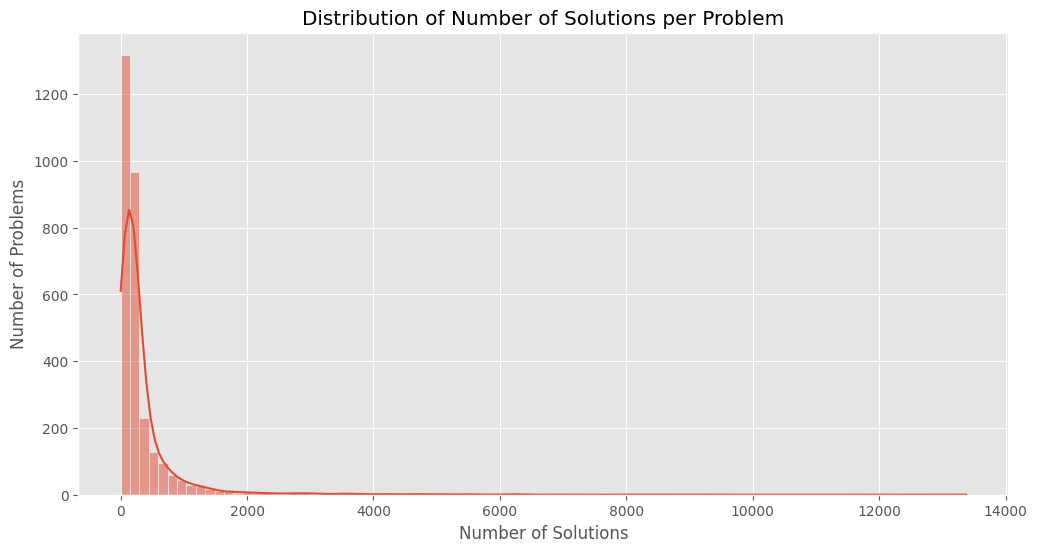

In [11]:
number_of_solutions_per_problem = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions)
num_bins = 90
interval_bin = (max(number_of_solutions_per_problem) - min(number_of_solutions_per_problem)) / num_bins

plt.figure(figsize=(12, 6))
sns.histplot(number_of_solutions_per_problem, bins=num_bins, kde=True)
plt.title('Distribution of Number of Solutions per Problem')
plt.xlabel('Number of Solutions')
plt.ylabel('Number of Problems')
plt.show()

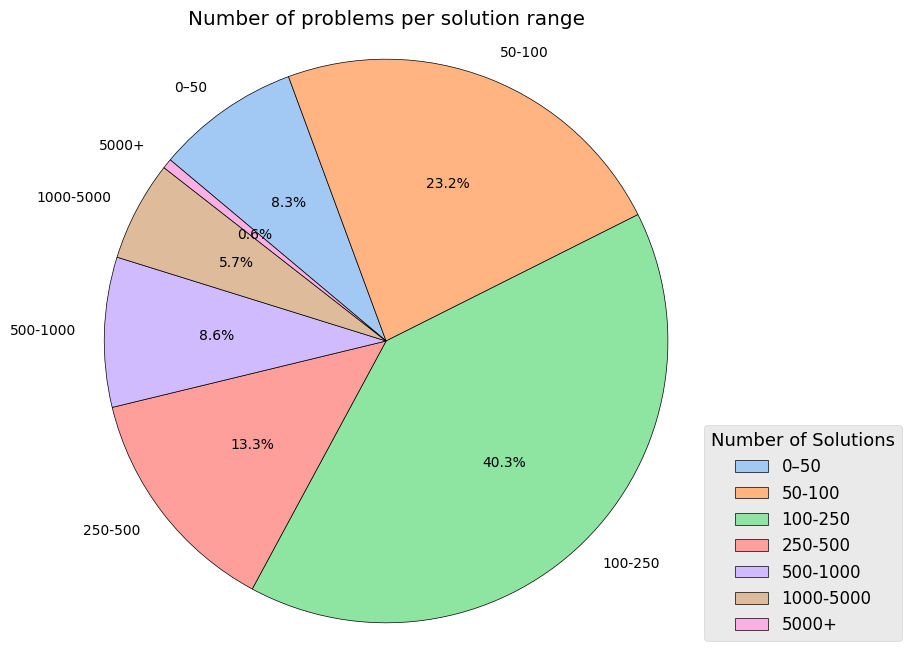

In [12]:
solution_counts = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(count_solutions)

bins = [0, 50, 100, 250, 500, 1000, 5000, float('inf')]
labels = ['0–50', '50-100', '100-250', '250-500', '500-1000', '1000-5000', '5000+']

solution_ranges = pd.cut(solution_counts, bins=bins, labels=labels, right=False)
range_counts = solution_ranges.value_counts().sort_index()
colors = sns.color_palette('pastel')[0:len(labels)]

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    range_counts, 
    labels=range_counts.index, 
    autopct='%1.1f%%', 
    startangle=140,
    counterclock=False,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Number of problems per solution range')
plt.axis('equal')
plt.legend(
    wedges, 
    range_counts.index, 
    title="Number of Solutions", 
    loc='lower left', 
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12,
    title_fontsize=13
)
plt.show()

## Description of the solutions

### Number of words in the problem description
We analyze the number of words in the problem description, comparing with and without punctuation and stop wwords. We perform some basic statistics on the number of words in the problem description, like the mean, maximum and minimum number of words. 

In [13]:
# Extract the text from the description column
def extract_text_from_description(description):
    if isinstance(description, dict):
        return description.get('text', '')
    return description

In [14]:
# Number of words in the description
def count_words(text):
    if isinstance(text, str):
        return len(re.findall(r'\w+', text))
    return 0

texts = df_problem_and_human_solutions_list['description'].apply(extract_text_from_description)
average_num_words = texts.apply(count_words).mean()
print(f"Average number of words in the description: {average_num_words:.2f}")
# Maximum number of words in the description
max_num_words = texts.apply(count_words).max()
print(f"Maximum number of words in the description: {max_num_words}")
# Minimum number of words in the description
min_num_words = texts.apply(count_words).min()
print(f"Minimum number of words in the description: {min_num_words}")

Average number of words in the description: 277.76
Maximum number of words in the description: 965
Minimum number of words in the description: 21


In [15]:
# Remove punctuation from the description and stop words
def remove_punctuation_and_stopwords(text):
    if isinstance(text, str):
        text = re.sub(regex_punctuation, '', text)
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        stop_words = set(stopwords.words('english'))
        words = [word for word in text.split() if word not in stop_words]
        return ' '.join(words)
    return text

texts_cleaned = texts.apply(remove_punctuation_and_stopwords)
# Count the number of words in the cleaned description
average_num_words_cleaned = texts_cleaned.apply(count_words).mean()
print(f"Average number of words in the cleaned description: {average_num_words_cleaned:.2f}")
# Maximum number of words in the cleaned description
max_num_words_cleaned = texts_cleaned.apply(count_words).max()
print(f"Maximum number of words in the cleaned description: {max_num_words_cleaned}")
# Minimum number of words in the cleaned description
min_num_words_cleaned = texts_cleaned.apply(count_words).min()
print(f"Minimum number of words in the cleaned description: {min_num_words_cleaned}")

Average number of words in the cleaned description: 131.35
Maximum number of words in the cleaned description: 422
Minimum number of words in the cleaned description: 12


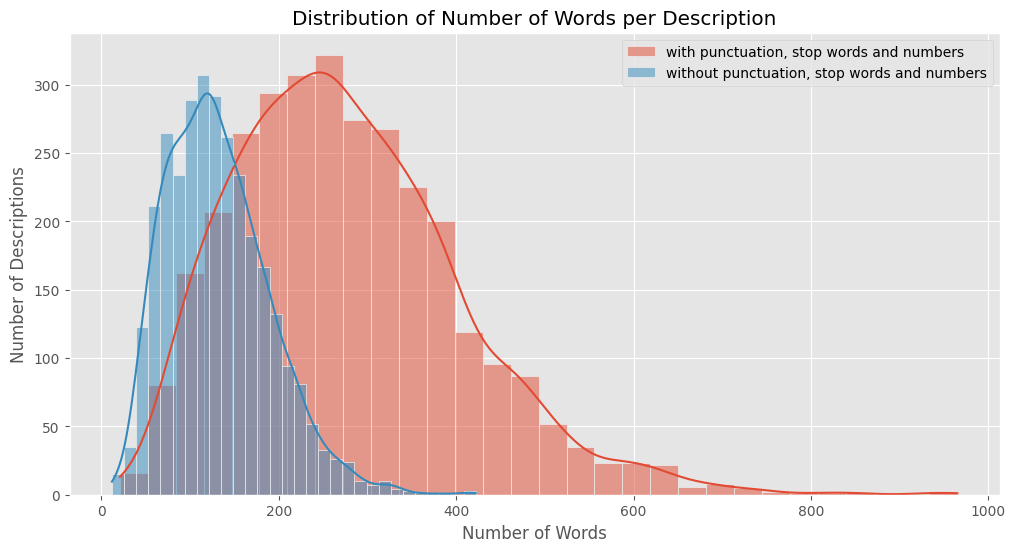

In [16]:
num_of_words_per_description = texts.apply(count_words)
num_of_words_per_description_cleaned = texts_cleaned.apply(count_words)
num_bins = 15
interval_bin = (max(num_of_words_per_description) - min(num_of_words_per_description)) / num_bins

plt.figure(figsize=(12, 6))
sns.histplot(num_of_words_per_description, bins=num_bins*2, kde=True, label='with punctuation, stop words and numbers') 
sns.histplot(num_of_words_per_description_cleaned, bins=num_bins*2, kde=True, label='without punctuation, stop words and numbers')
plt.title('Distribution of Number of Words per Description')
plt.xlabel('Number of Words')
plt.ylabel('Number of Descriptions')
plt.legend()
plt.show()

### Description Vocabulary
We analyze the vocabulary of the problem descriptions. 

In [17]:
# Collect all descriptions
all_descriptions = df_problem_and_human_solutions_list['description'].dropna().tolist()
# Extract text from descriptions
all_texts = [desc.get('text', '') for desc in all_descriptions]
# Join all texts into a single string
all_text = ' '.join(all_texts)
# Count the number of unique words in the vocabulary
unique_words = set(re.findall(r'\w+', all_text))
print(f"Number of unique words in vocabulary of descriptions: {len(unique_words)}")

Number of unique words in vocabulary of descriptions: 18037


In [18]:
# Remove punctuation, stop words, numbers, and lowercase the words
words_cleaned = []
for text in all_texts:
    text = re.sub(regex_punctuation, '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stop_words]
    words_cleaned.extend(words)

unique_words_cleaned = set(words_cleaned)
print(f"Number of unique words in vocabulary of descriptions (without punctuation and stop words): {len(unique_words_cleaned)}")

Number of unique words in vocabulary of descriptions (without punctuation and stop words): 14447


In [19]:
# Print the most 50 common words
word_counts = Counter(words_cleaned)
most_common_words = word_counts.most_common(50)
print("Most common words in the descriptions:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most common words in the descriptions:
input: 13177
n: 11640
≤: 11555
output: 11297
number: 7885
first: 6063
line: 5712
one: 5293
contains: 4791
print: 4409
—: 4372
integer: 4339
integers: 4104
second: 3696
b: 3520
x: 3258
two: 3234
example: 3209
test: 3062
given: 2846
string: 2713
k: 2662
examples: 2533
note: 2398
ai: 2229
case: 2186
possible: 2020
ith: 1941
\leq: 1932
following: 1911
single: 1903
length: 1786
array: 1692
sequence: 1613
numbers: 1599
yes: 1517
c: 1434
find: 1397
answer: 1381
minimum: 1310
equal: 1296
order: 1240
third: 1146
maximum: 1133
sample: 1089
elements: 1084
exactly: 1072
time: 1056
sum: 1054
lines: 1050


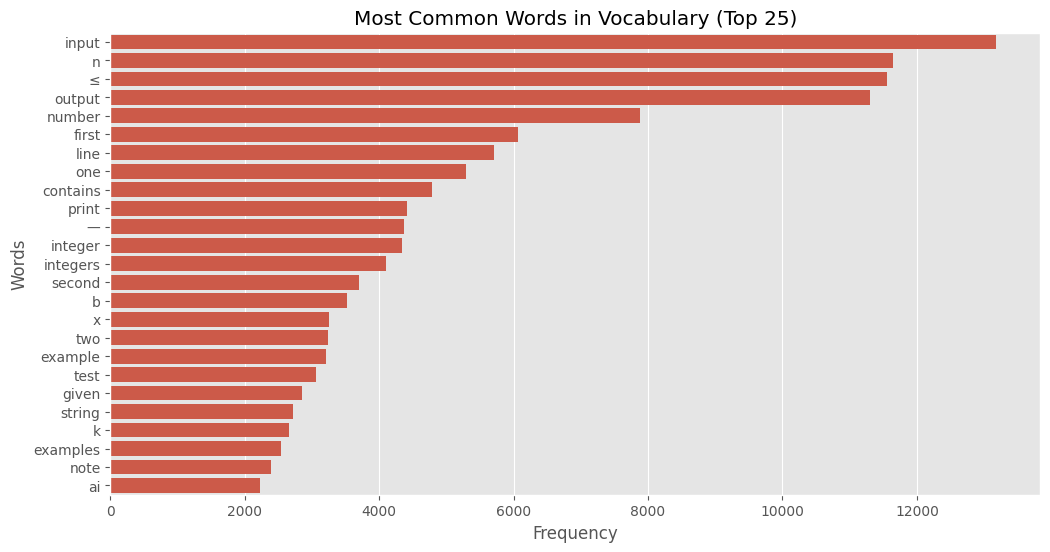

In [20]:
# Most common words in the vocabulary
def plot_most_common_words(words, num_words=20):
    word_counts = Counter(words)
    most_common = word_counts.most_common(num_words)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Most Common Words in Vocabulary (Top {num_words})')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()
plot_most_common_words(words_cleaned, num_words=25)

### Number of words per frequency in the problem description

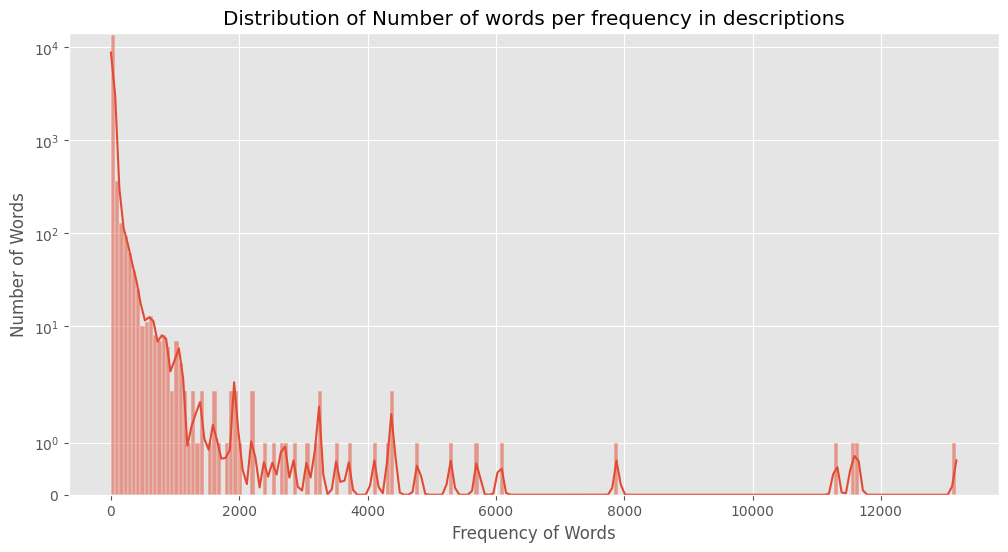

In [21]:
words_frequency = list(Counter(words_cleaned).values())
num_bins = 100
interval_bin = (max(words_frequency) - min(words_frequency)) / num_bins
plt.figure(figsize=(12, 6))
sns.histplot(words_frequency, bins=num_bins*2, kde=True)
plt.title('Distribution of Number of words per frequency in descriptions')
plt.xlabel('Frequency of Words')
plt.ylabel('Number of Words')
plt.yscale('symlog')
plt.show()


In [22]:
# Calculate the maximum words frequency
max_frequency = max(words_frequency)
print(f"Maximum frequency of words in descriptions: {max_frequency}")
# Calculate the minimum words frequency
min_frequency = min(words_frequency)
print(f"Minimum frequency of words in descriptions: {min_frequency}")
# Calculate the average words frequency
average_frequency = sum(words_frequency) / len(words_frequency)
print(f"Average frequency of words in descriptions: {average_frequency:.2f}")

Maximum frequency of words in descriptions: 13177
Minimum frequency of words in descriptions: 1
Average frequency of words in descriptions: 29.56


### Word Cloud of the problem description

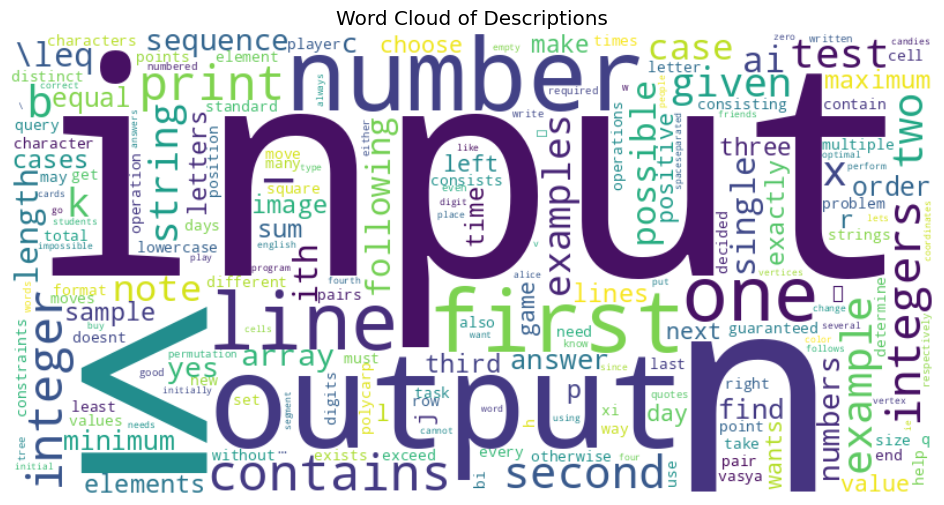

In [23]:
# Create a word cloud
word_counter = Counter(words_cleaned)
world_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

plt.figure(figsize=(12, 6))
plt.imshow(world_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

### N-Grams of the problem description
We analyze the most common n-grams in the problem description. This can help us to understand the most common phrases and expressions used in the problem descriptions.

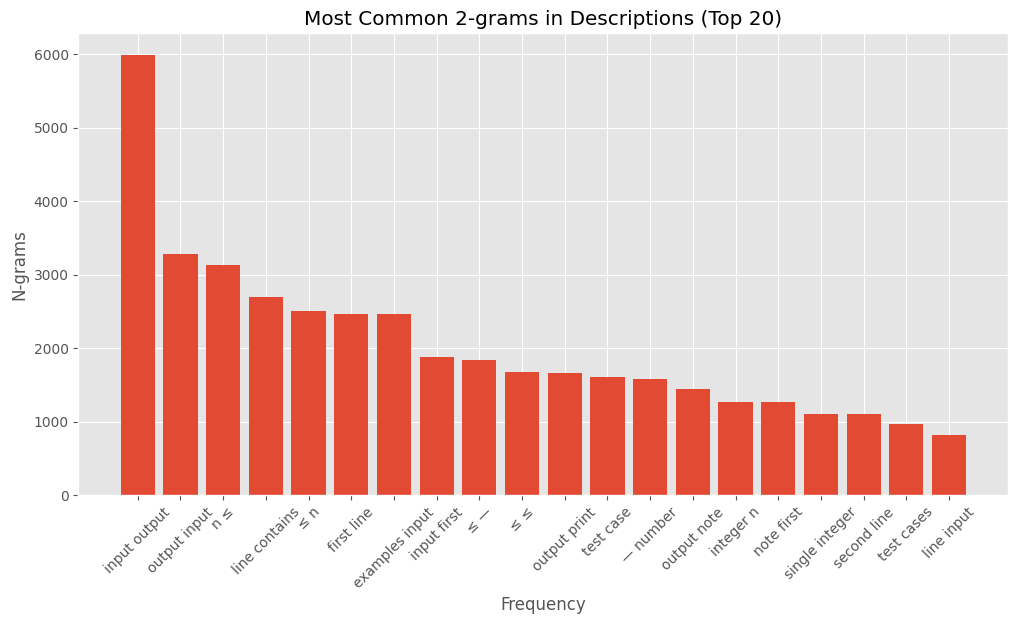

In [24]:
# 2-grams
n = 2
tokenized_texts = texts_cleaned.apply(lambda x: x.split())

ngrams_list = []
for tokens in tokenized_texts:
    ngrams_in_text = list(ngrams(tokens, n))  # n-grams per singola descrizione
    ngrams_list.extend(ngrams_in_text) 
    
ngrams_counter = Counter(ngrams_list)

N = 20
most_common_ngrams = ngrams_counter.most_common(N)
ngram_tuples, counts = zip(*most_common_ngrams)
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

plt.figure(figsize=(12, 6))
plt.bar(ngram_strings, counts)
plt.title(f'Most Common {n}-grams in Descriptions (Top {N})')
plt.xlabel('Frequency')
plt.ylabel(f'N-grams')
plt.xticks(rotation=45)
plt.show()


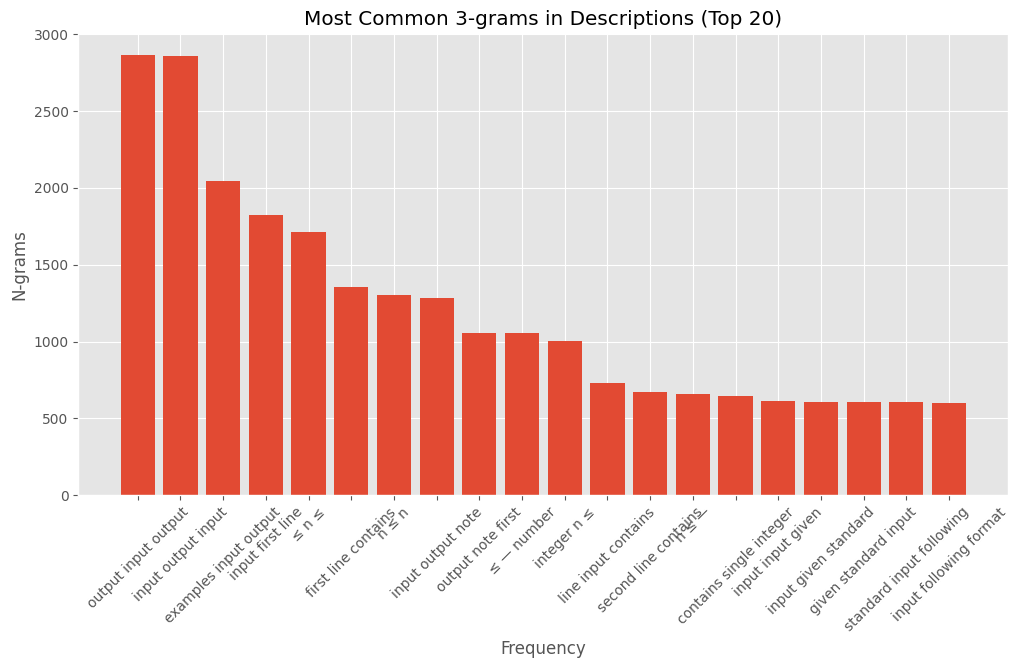

In [25]:
# 3-grams
n = 3
tokenized_texts = texts_cleaned.apply(lambda x: x.split())

ngrams_list = []
for tokens in tokenized_texts:
    ngrams_in_text = list(ngrams(tokens, n))
    ngrams_list.extend(ngrams_in_text) 
    
ngrams_counter = Counter(ngrams_list)

N = 20
most_common_ngrams = ngrams_counter.most_common(N)
ngram_tuples, counts = zip(*most_common_ngrams)
ngram_strings = [" ".join(ngram) for ngram in ngram_tuples]

plt.figure(figsize=(12, 6))
plt.bar(ngram_strings, counts)
plt.title(f'Most Common {n}-grams in Descriptions (Top {N})')
plt.xlabel('Frequency')
plt.ylabel(f'N-grams')
plt.xticks(rotation=45)
plt.show()


### Duplicated descriptions
We check if there are any duplicated descriptions in the problem descriptions. We can see that there are some duplicated descriptions, but they are not very frequent.

In [26]:
# Unique text in the description
description_counts = texts.value_counts()
# Duplicate texts in the description
duplicate_descriptions = description_counts[description_counts > 1]

print("Number of unique descriptions:", len(description_counts))
print("Number of duplicated descriptions:", len(duplicate_descriptions))

Number of unique descriptions: 3031
Number of duplicated descriptions: 74


### Translated descriptions

By looking at the description column of *df_problem_and_human_solutions_list*, there is also a boolean value *is_description_translated*. If this value is set to True, there is the untranslated description of the problem. !CHECK

In [27]:
# Check if the 'description' column is a string and convert it to a dictionary
if isinstance(df_problem_and_human_solutions_list['description'].iloc[0], str):
    df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(json.loads)

# Check if is_description_translated is True
filtered_df = df_problem_and_human_solutions_list[df_problem_and_human_solutions_list['description'].apply(
    lambda x: isinstance(x, dict) and x.get('is_description_translated') is True
)]

print(f"Number of rows where is_description_translated is True: {len(filtered_df)}")

Number of rows where is_description_translated is True: 29


In [28]:
# Remove from description is_description_translated and untranslated_text
def remove_untranslated_text(description):
    if isinstance(description, dict):
        description.pop('is_description_translated', None)
        description.pop('untranslated_text', None)
    return description

df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(remove_untranslated_text)

In [29]:
# Remove dict in description and keep only the text
df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(extract_text_from_description)

## Code Solutions

### Number of words in the code solutions

In [30]:
# Extract the code from the solution column
def extract_code_from_solution(solution, other_data=None):
    if not isinstance(solution, list):
        return []

    rows = []
    for s in solution:
        code = s.get('solution_code', '')
        if code:
            row = {'solution_id': s.get('solution_id', ''), 'solution_code': code}
            if other_data:
                row.update(other_data)
            rows.append(row)
    return rows

In [31]:
# Extract the code from the solution column
extracted_codes = df_problem_and_human_solutions_list_filtered['correct_solution_list'].apply(extract_code_from_solution)

# Flatten the list of lists into a single list
df_codes = pd.DataFrame(
    [item for sublist in extracted_codes for item in sublist],
    columns=['solution_id', 'solution_code']
)

# Explode the DataFrame to have one row per solution code
df_codes = df_codes.explode('solution_code').reset_index(drop=True)


In [32]:
# Count the number of words in the code
def count_words_in_code(code):
    if isinstance(code, str):
        return len(re.findall(r'\w+', code))
    return 0

words_in_code = df_codes['solution_code'].apply(count_words_in_code)
# Count average number of words in the code
average_num_words_in_code = words_in_code.mean()
print(f"Average number of words in the code: {average_num_words_in_code:.2f}")
# Count maximum number of words in the code
max_num_words_in_code = words_in_code.max()
print(f"Maximum number of words in the code: {max_num_words_in_code}")
# Count minimum number of words in the code
min_num_words_in_code = words_in_code.min()
print(f"Minimum number of words in the code: {min_num_words_in_code}")

Average number of words in the code: 62.22
Maximum number of words in the code: 16423
Minimum number of words in the code: 2


In [33]:
# Remove punctuation from the code and numbers
def remove_punctuation_and_numbers(code):
    if isinstance(code, str):
        code = re.sub(regex_punctuation, '', code)
        code = re.sub(r'\d+', '', code)
        return code
    return code

df_codes_cleaned = df_codes.copy()
df_codes_cleaned['solution_code'] = df_codes_cleaned['solution_code'].apply(remove_punctuation_and_numbers)

# Count the average number of words in the cleaned code
average_num_words_in_code_cleaned = df_codes_cleaned['solution_code'].apply(count_words_in_code).mean()
print(f"Average number of words in the cleaned code: {average_num_words_in_code_cleaned:.2f}")
# Count the maximum number of words in the cleaned code
max_num_words_in_code_cleaned = df_codes_cleaned['solution_code'].apply(count_words_in_code).max()
print(f"Maximum number of words in the cleaned code: {max_num_words_in_code_cleaned}")
# Count the minimum number of words in the cleaned code
min_num_words_in_code_cleaned = df_codes_cleaned['solution_code'].apply(count_words_in_code).min()
print(f"Minimum number of words in the cleaned code: {min_num_words_in_code_cleaned}")

Average number of words in the cleaned code: 34.40
Maximum number of words in the cleaned code: 4577
Minimum number of words in the cleaned code: 1


In [34]:
# Count the number of lines in the code
def count_lines_in_code(code):
    if isinstance(code, str):
        return len(code.split('\n'))
    return 0

lines_in_code = df_codes['solution_code'].apply(count_lines_in_code)
# Count average number of lines in the code
average_num_lines_in_code = lines_in_code.mean()
print(f"Average number of lines in the code: {average_num_lines_in_code:.2f}")
# Count maximum number of lines in the code
max_num_lines_in_code = lines_in_code.max()
print(f"Maximum number of lines in the code: {max_num_lines_in_code}")
# Count minimum number of lines in the code
min_num_lines_in_code = lines_in_code.min()
print(f"Minimum number of lines in the code: {min_num_lines_in_code}")

Average number of lines in the code: 18.74
Maximum number of lines in the code: 4131
Minimum number of lines in the code: 1


### Solutions Vocabulary

In [35]:
# Collect all codes
all_codes = df_codes['solution_code'].dropna().tolist()
# Join all codes into a single string
all_code = ' '.join(all_codes)
# Count the number of unique words in the vocabulary
unique_words_code = set(re.findall(r'\w+', all_code))
print(f"Number of unique words in vocabulary of codes: {len(unique_words_code)}")

Number of unique words in vocabulary of codes: 308726


In [36]:
# Remove punctuation, stop words, numbers, and lowercase the words
words_code_cleaned = []
for code in all_codes:
    code = re.sub(regex_punctuation, '', code)
    code = code.lower()
    code = re.sub(r'\d+', '', code)
    stop_words = set(stopwords.words('english'))
    words = [word for word in code.split() if word not in stop_words]
    words_code_cleaned.extend(words)
unique_words_code_cleaned = set(words_code_cleaned)
print(f"Number of unique words in vocabulary of codes (without punctuation and stop words): {len(unique_words_code_cleaned)}")


Number of unique words in vocabulary of codes (without punctuation and stop words): 1235003


In [37]:
# Print the most 50 common words
word_counts_code = Counter(words_code_cleaned)
most_common_words_code = word_counts_code.most_common(50)
print("Most common words in the codes:")
for word, count in most_common_words_code:
    print(f"{word}: {count}")

Most common words in the codes:
n: 1081787
else: 887885
x: 570688
def: 507105
return: 482510
b: 468580
intinput: 436223
inputsplit: 418339
import: 394774
rangen: 367160
c: 343545
k: 332409
ans: 316020
print: 308433
j: 265502
input: 253418
l: 249871
elif: 228968
break: 214213
range: 200700
r: 177891
printyes: 169026
printno: 163920
true: 151483
p: 151183
count: 148440
main: 142907
mapint: 139055
nintinput: 137034
listmapint: 123668
false: 119496
ai: 107432
printans: 104818
math: 101872
sys: 100210
res: 99415
ranget: 99100
rangeintinput: 96308
f: 83540
cnt: 75054
si: 74123
lambda: 70903
flag: 70150
q: 67121
arr: 66121
v: 65155
num: 65055
w: 63963
ab: 59956
z: 59361


In [38]:
# Remove single characters
words_code_no_single_characters = [word for word in words_code_cleaned if len(word) > 1]

most_common_words_code_no_single_characters = Counter(words_code_no_single_characters).most_common(50)
print("Most common words in the codes (without single characters):")
for word, count in most_common_words_code_no_single_characters:
    print(f"{word}: {count}")


Most common words in the codes (without single characters):
else: 887885
def: 507105
return: 482510
intinput: 436223
inputsplit: 418339
import: 394774
rangen: 367160
ans: 316020
print: 308433
input: 253418
elif: 228968
break: 214213
range: 200700
printyes: 169026
printno: 163920
true: 151483
count: 148440
main: 142907
mapint: 139055
nintinput: 137034
listmapint: 123668
false: 119496
ai: 107432
printans: 104818
math: 101872
sys: 100210
res: 99415
ranget: 99100
rangeintinput: 96308
cnt: 75054
si: 74123
lambda: 70903
flag: 70150
arr: 66121
num: 65055
ab: 59956
continue: 57707
collections: 57108
name: 55805
intx: 54908
mapintinputsplit: 52143
li: 51353
listmapintinputsplit: 45931
printn: 45591
mod: 45548
sum: 43444
tintinput: 41564
temp: 40938
prints: 40763
end: 40275


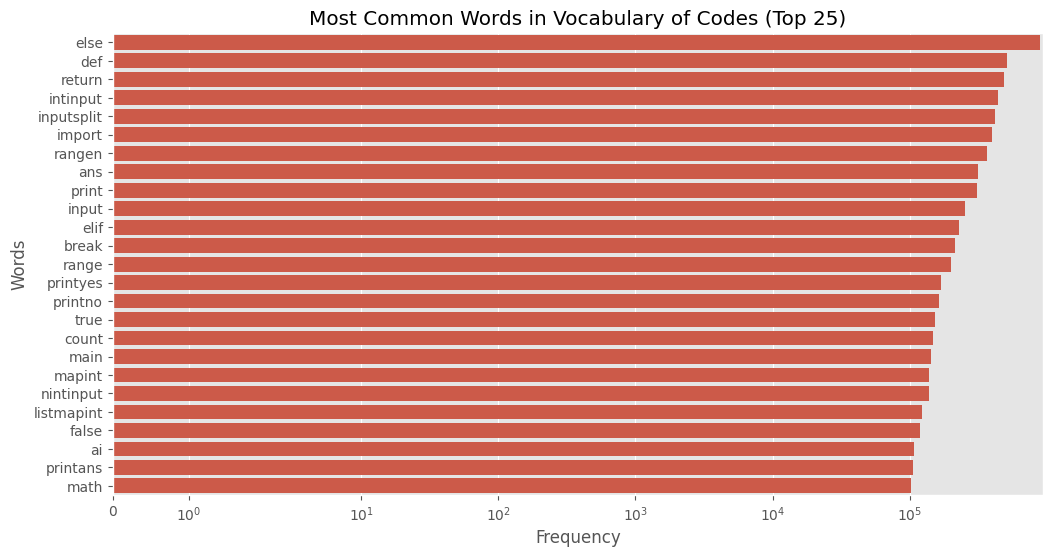

In [39]:
# Most common words in the vocabulary
def plot_most_common_words_code(words, num_words=20):
    word_counts = Counter(words)
    most_common = word_counts.most_common(num_words)
    words, counts = zip(*most_common)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Most Common Words in Vocabulary of Codes (Top {num_words})')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.xscale('symlog')
    plt.show()
    
plot_most_common_words_code(words_code_no_single_characters, num_words=25)

### Number of words per frequency in the code solutions
We analyze the most common words in the code solutions. This can help us to understand the most common words used in the code solutions.

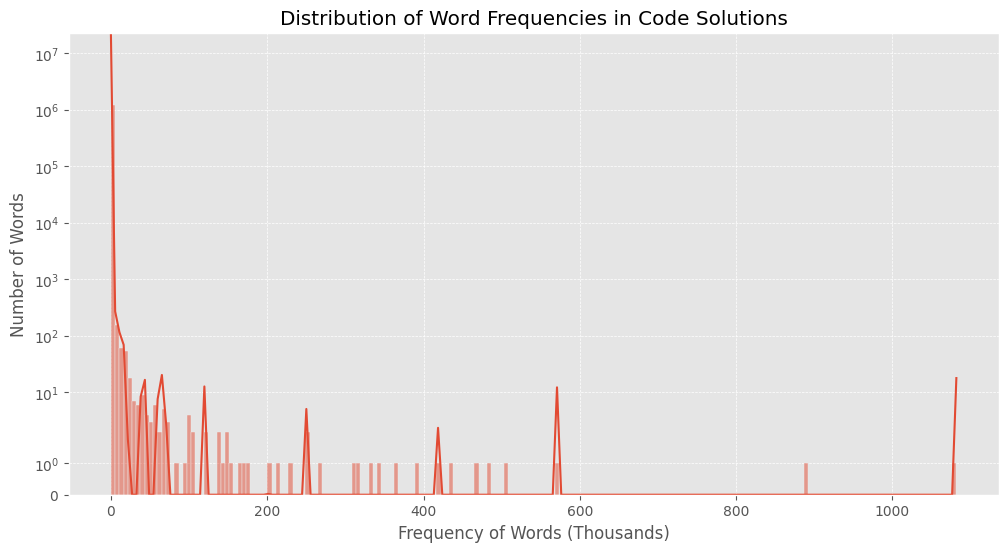

In [40]:
words_code_frequency = list(Counter(words_code_cleaned).values())
words_code_frequency_k = [freq / 1000 for freq in words_code_frequency]

num_bins = 100
plt.figure(figsize=(12, 6))
sns.histplot(words_code_frequency_k, bins=num_bins*2, kde=True)
plt.title('Distribution of Word Frequencies in Code Solutions')
plt.xlabel('Frequency of Words (Thousands)')
plt.ylabel('Number of Words')
plt.yscale('symlog')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [41]:
# Calculate the average words frequency
average_frequency_code = sum(words_code_frequency) / len(words_code_frequency)
print(f"Average frequency of words in codes: {average_frequency_code:.2f}")
# Calculate the maximum words frequency
max_frequency_code = max(words_code_frequency)
print(f"Maximum frequency of words in codes: {max_frequency_code}")
# Calculate the minimum words frequency
min_frequency_code = min(words_code_frequency)
print(f"Minimum frequency of words in codes: {min_frequency_code}") 

Average frequency of words in codes: 20.59
Maximum frequency of words in codes: 1081787
Minimum frequency of words in codes: 1


### Word Cloud of the code solutions

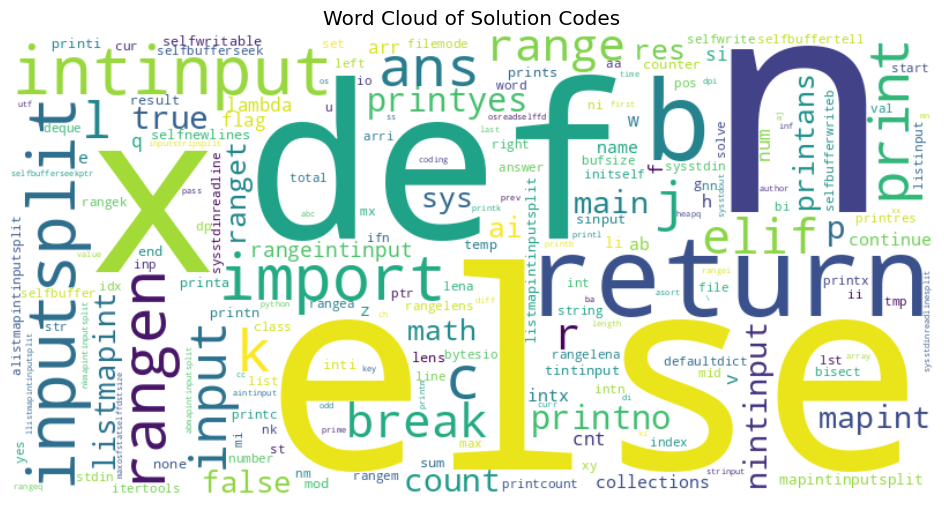

In [42]:
# Create a word cloud
word_code_counter = Counter(words_code_cleaned)
world_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_code_counter)

plt.figure(figsize=(12, 6))
plt.imshow(world_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Solution Codes')
plt.show()

### Duplicated code solutions
We check if there are any duplicated solutions in the code solutions. We can see that there are some duplicated code solutions.

In [43]:
# Count the duplicate codes
duplicate_codes = df_codes['solution_code'].value_counts()
print("Number of unique codes:", len(duplicate_codes))
print("Number of duplicated codes:", len(duplicate_codes[duplicate_codes > 1]))

Number of unique codes: 1034514
Number of duplicated codes: 7056


In [44]:
# Create a dataframe with the solution ids of the duplicated codes
duplicate_codes_df = df_codes[df_codes['solution_code'].duplicated(keep=False)]
duplicate_codes_df = duplicate_codes_df.sort_values(by='solution_code').reset_index(drop=True)
# Create a dataframe with three columns: solution_ids, solution_code and number of duplicates
duplicate_codes_df = duplicate_codes_df.groupby('solution_code').agg(
    solution_ids=('solution_id', lambda x: ', '.join(x)),
    count=('solution_id', 'size')
).reset_index()
# Sort the dataframe by count in descending order
duplicate_codes_df = duplicate_codes_df.sort_values(by='count', ascending=False).reset_index(drop=True)


In [45]:
duplicate_codes_df

,solution_code,solution_ids,count
0,"def getmid(s, e, count):\n mx = -1\n for...","817_1046, 2986_83, 3040_96",3
1,import sys\nimport collections\nimport threadi...,"2986_23, 3040_118, 817_246",3
2,"import os\nimport sys\nfrom io import BytesIO,...","3040_7, 817_805, 2986_53",3
3,#!/usr/bin/env python\nimport os\nimport sys\n...,"2986_80, 3040_28, 817_663",3
4,import sys\nfrom array import array # noqa: F...,"817_261, 2986_45, 3040_98",3
...,...,...,...
7051,from collections import Counter\n\n\nin_n = in...,"2470_516, 747_4",2
7052,from collections import Counter\n\n\ndef solve...,"1452_55, 791_39",2
7053,from collections import Counter\n\n\ndef read_...,"791_37, 1452_15",2
7054,from collections import Counter\n\n\ndef peres...,"2536_199, 2813_40",2


In [46]:
# Print maximum number of duplicates
max_duplicates = duplicate_codes_df['count'].max()
print(f"Maximum number of duplicates: {max_duplicates}")

Maximum number of duplicates: 3


In [47]:
# Create a dataframe with solution ids, solution codes and descriptions
solution_entries = []

for idx, row in df_problem_and_human_solutions_list_filtered.iterrows():
    description = row['description']
    text = description.get('text', '')
    correct_solutions = row['correct_solution_list']
    
    if isinstance(correct_solutions, list):
        for sol in correct_solutions:
            solution_entries.append({
                'solution_id': sol.get('solution_id'),
                'solution_code': sol.get('solution_code'),
                'description': text
            })

df_solutions_expanded = pd.DataFrame(solution_entries)

print(f"Shape df_solutions_expanded: {df_solutions_expanded.shape}")
df_solutions_expanded.head()

Shape df_solutions_expanded: (1041578, 3)


,solution_id,solution_code,description
0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,Xenia has a set of weights and pan scales. Eac...
1,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,Xenia has a set of weights and pan scales. Eac...
2,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,Xenia has a set of weights and pan scales. Eac...
3,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",Xenia has a set of weights and pan scales. Eac...
4,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",Xenia has a set of weights and pan scales. Eac...


In [48]:
# Add the time and space complexity labels to the solutions
df_solutions_full = df_solutions_expanded.merge(
    df_complexity_labels_light_filtered[['solution_id', 'time_complexity_inferred', 'space_complexity_inferred']],
    on='solution_id',
    how='left'
)

print(f"Shape df_solutions_full: {df_solutions_full.shape}")
df_solutions_full.head()

Shape df_solutions_full: (1041578, 5)


,solution_id,solution_code,description,time_complexity_inferred,space_complexity_inferred
0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,Xenia has a set of weights and pan scales. Eac...,O(1),O(n**2)
1,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,Xenia has a set of weights and pan scales. Eac...,O(1),O(1)
2,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,Xenia has a set of weights and pan scales. Eac...,O(1),O(1)
3,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",Xenia has a set of weights and pan scales. Eac...,O(1),O(1)
4,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",Xenia has a set of weights and pan scales. Eac...,O(1),O(1)


In [49]:
# Check for solutions with same description and time/space complexity
results = []

for idx, row in duplicate_codes_df.iterrows():
    solution_ids = row['solution_ids'].split(', ')
    
    subset = df_solutions_full[df_solutions_full['solution_id'].isin(solution_ids)]
    
    unique_descriptions = subset['description'].dropna().unique()
    unique_time_complexities = subset['time_complexity_inferred'].dropna().unique()
    unique_space_complexities = subset['space_complexity_inferred'].dropna().unique()
    
    same_description = len(unique_descriptions) == 1
    same_time_complexity = len(unique_time_complexities) == 1
    same_space_complexity = len(unique_space_complexities) == 1
    
    results.append({
        'solution_code': row['solution_code'],
        'solution_ids': row['solution_ids'],
        'count': row['count'],
        'same_description': same_description,
        'same_time_complexity': same_time_complexity,
        'same_space_complexity': same_space_complexity
    })

check_duplicates_df = pd.DataFrame(results)

# Inconsistencies
inconsistencies = check_duplicates_df[
    (~check_duplicates_df['same_description']) |
    (~check_duplicates_df['same_time_complexity']) |
    (~check_duplicates_df['same_space_complexity'])
]
# Consistencies
consistencies = check_duplicates_df[
    (check_duplicates_df['same_description']) &
    (check_duplicates_df['same_time_complexity']) &
    (check_duplicates_df['same_space_complexity'])
]


check_duplicates_df.head()

,solution_code,solution_ids,count,same_description,same_time_complexity,same_space_complexity
0,"def getmid(s, e, count):\n mx = -1\n for...","817_1046, 2986_83, 3040_96",3,False,False,True
1,import sys\nimport collections\nimport threadi...,"2986_23, 3040_118, 817_246",3,False,False,True
2,"import os\nimport sys\nfrom io import BytesIO,...","3040_7, 817_805, 2986_53",3,False,False,False
3,#!/usr/bin/env python\nimport os\nimport sys\n...,"2986_80, 3040_28, 817_663",3,False,False,False
4,import sys\nfrom array import array # noqa: F...,"817_261, 2986_45, 3040_98",3,False,False,True


In [50]:
print(f"Number of solutions with inconsistencies: {len(inconsistencies)}")
print(f"Number of solutions with different descriptions:", len(inconsistencies[inconsistencies['same_description'] == False]))
print(f"Number of solutions with different time complexities:", len(inconsistencies[inconsistencies['same_time_complexity'] == False]))
print(f"Number of solutions with different space complexities:", len(inconsistencies[inconsistencies['same_space_complexity'] == False]))
print(f"Number of solutions with same description, time complexity and space complexity:", len(consistencies))

Number of solutions with inconsistencies: 3857
Number of solutions with different descriptions: 2353
Number of solutions with different time complexities: 1804
Number of solutions with different space complexities: 1467
Number of solutions with same description, time complexity and space complexity: 3199


### Patterns in the solutions
We analyze the patterns in the solutions, in particular looking for the most common syntax expression in Python, for example:
for loops, while loops, functions definitions, recursion, nested loops.

In order to detect possibile correlations between the patterns and the time and space complexities.

In [51]:
def tokenize_code(code):
    tokens = []
    try:
        code_io = io.StringIO(code)
        for toknum, tokval, _, _, _ in tokenize.generate_tokens(code_io.readline):
            if tokval.strip() and tokval.isalnum() and not tokval.isdigit() and not tokval.isalpha():
                tokens.append(tokval)
    except tokenize.TokenError:
        pass 
    return tokens

def analyze_token_frequencies(codes):
    all_tokens = []
    for code in codes:
        tokens = tokenize_code(code)
        all_tokens.extend(tokens)
    return Counter(all_tokens)

In [52]:
codes = df_codes['solution_code'].dropna().tolist()

frequencies = analyze_token_frequencies(codes)
print(frequencies.most_common(30))

[('s1', 56157), ('l1', 38151), ('s2', 38136), ('x1', 28863), ('a1', 28618), ('c1', 24797), ('l2', 23054), ('n1', 23005), ('x2', 22451), ('y1', 20715), ('a2', 19460), ('c2', 16938), ('y2', 16105), ('n2', 15918), ('list1', 13956), ('d1', 13789), ('b1', 13056), ('k1', 12180), ('p1', 11913), ('str1', 11765), ('t1', 11207), ('r1', 11194), ('k2', 11120), ('d2', 11067), ('sum1', 10939), ('ans1', 10642), ('p2', 10270), ('r2', 9491), ('ans2', 8881), ('m1', 8493)]


In [53]:
# Function to find patterns in the code
def find_patterns_in_code(code):
    patterns = {
        'functions': re.findall(r'\bdef\s+\w+\s*\(', code),
        'for_loops': re.findall(r'\bfor\s+\w+\s+in\s+', code),
        'while_loops': re.findall(r'\bwhile\s+\w*', code),
        'sort_calls': re.findall(r'\.sort\(|sorted\(', code),
        'append_calls': re.findall(r'\.append\(', code),
        'insert_calls': re.findall(r'\.insert\(', code),
        'pop_calls': re.findall(r'\.pop\(', code),
        'list_usage': re.findall(r'\[.*?\]', code),
        'dict_usage': re.findall(r'\{.*?:.*?\}', code),
        'set_usage': re.findall(r'\{.*?\}', code),
    }
    
    # Recursive function detection
    recursive = False
    function_names = [re.search(r'def\s+(\w+)\s*\(', match).group(1) for match in patterns['functions']]
    for func in function_names:
        if len(re.findall(rf'\b{func}\s*\(', code)) > 1: 
            recursive = True
            break
    
    # Nesting level detection
    nesting_level = code.count('for ') + code.count('while ')
    max_nesting = 0
    for line in code.splitlines():
        if 'for ' in line or 'while ' in line:
            indent = len(line) - len(line.lstrip(' '))
            max_nesting = max(max_nesting, indent)
    
    # Nested loops detection
    nested_loops = nesting_level > 1

    return {
        'n_functions': len(patterns['functions']),
        'n_for_loops': len(patterns['for_loops']),
        'n_while_loops': len(patterns['while_loops']),
        'recursive': recursive,
        'n_sort_calls': len(patterns['sort_calls']),
        'n_append_calls': len(patterns['append_calls']),
        'n_insert_calls': len(patterns['insert_calls']),
        'n_pop_calls': len(patterns['pop_calls']),
        'list_usage': len(patterns['list_usage']),
        'dict_usage': len(patterns['dict_usage']),
        'set_usage': len(patterns['set_usage']),
        'nesting_level': nesting_level,
        'max_indent_nesting': max_nesting,
        'nested_loops': nested_loops
    }

In [54]:
pattern_results = [find_patterns_in_code(code) for code in df_codes['solution_code']]
# Convert the list of dictionaries to a DataFrame
df_patterns = pd.DataFrame(pattern_results)


In [55]:
df_patterns

,n_functions,n_for_loops,n_while_loops,recursive,n_sort_calls,n_append_calls,n_insert_calls,n_pop_calls,list_usage,dict_usage,set_usage,nesting_level,max_indent_nesting,nested_loops
0,0,1,1,False,0,1,0,1,3,0,0,3,4,True
1,1,2,0,True,0,0,0,0,3,0,0,2,2,True
2,3,1,1,True,0,1,0,1,6,2,2,3,4,True
3,0,1,1,False,0,1,0,1,3,0,0,3,4,True
4,1,1,0,True,0,1,0,0,3,0,0,1,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041573,0,1,0,False,0,0,0,0,0,0,0,1,0,False
1041574,0,1,0,False,0,0,0,0,0,0,0,1,0,False
1041575,0,1,0,False,0,0,0,0,0,0,0,1,0,False
1041576,0,1,0,False,0,0,0,0,0,0,0,1,0,False


In [56]:
# Count for each pattern the total number of occurrences
pattern_counts = df_patterns.sum()
# Convert to a DataFrame for better visualization
pattern_counts_df = pd.DataFrame(pattern_counts).reset_index()
# Sort the DataFrame by count in descending order
pattern_counts_df = pattern_counts_df.sort_values(by=0, ascending=False)
pattern_counts_df.columns = ['Pattern', 'Count']
pattern_counts_df

,Pattern,Count
8,list_usage,3885353
11,nesting_level,1916265
12,max_indent_nesting,1828151
1,n_for_loops,1607609
0,n_functions,506976
13,nested_loops,439547
5,n_append_calls,376392
2,n_while_loops,254284
3,recursive,182361
4,n_sort_calls,135992


In [57]:
# Add solution_id to the DataFrame
df_patterns['solution_id'] = df_codes['solution_id']

In [58]:
# Merge df_patterns with df_codes on solution_id
df_patterns_codes = pd.merge(df_codes, df_patterns, on='solution_id', how='left')
# Merge df_patterns_codes with df_complexity_labels_light on solution_id maintaining time_complexity_inferred and space_complexity_inferred
df_patterns_codes = pd.merge(df_patterns_codes, df_complexity_labels_light[['solution_id', 'time_complexity_inferred', 'space_complexity_inferred']], on='solution_id', how='left')

In [59]:
df_patterns_codes

,solution_id,solution_code,n_functions,n_for_loops,n_while_loops,recursive,n_sort_calls,n_append_calls,n_insert_calls,n_pop_calls,list_usage,dict_usage,set_usage,nesting_level,max_indent_nesting,nested_loops,time_complexity_inferred,space_complexity_inferred
0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,0,1,1,False,0,1,0,1,3,0,0,3,4,True,O(1),O(n**2)
1,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,1,2,0,True,0,0,0,0,3,0,0,2,2,True,O(1),O(1)
2,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,3,1,1,True,0,1,0,1,6,2,2,3,4,True,O(1),O(1)
3,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",0,1,1,False,0,1,0,1,3,0,0,3,4,True,O(1),O(1)
4,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",1,1,0,True,0,1,0,0,3,0,0,1,8,False,O(1),O(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041573,3104_195,a=100000\n\nfor i in range(int(input())):\n ...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)
1041574,3104_196,import sys\nw=int(input())\nbase=100000\nfor i...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)
1041575,3104_197,n = int(input())\ns = 100000\nfor i in range(n...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)
1041576,3104_198,n=int(input())\nz=100000\nfor i in range(n):\n...,0,1,0,False,0,0,0,0,0,0,0,1,0,False,O(nlogn),O(n)


## Time and Space Complexity
We analyze the time and space complexity of the solutions. First, we check the total number of distinct values both for time and space complexity and we print the most common values.

In [60]:
# Count the number of distinct time complexities
distinct_time_complexities = df_complexity_labels_light_filtered['time_complexity_inferred'].nunique()
print(f"Number of distinct time complexities: {distinct_time_complexities}")

# Count the number of distinct space complexities
distinct_space_complexities = df_complexity_labels_light_filtered['space_complexity_inferred'].nunique()
print(f"Number of distinct space complexities: {distinct_space_complexities}")

Number of distinct time complexities: 439
Number of distinct space complexities: 262


In [61]:
# Print the most common time complexities
time_complexity_counts = df_complexity_labels_light_filtered['time_complexity_inferred'].value_counts()
print("Most common time complexities:")
print(time_complexity_counts.head(10))

Most common time complexities:
time_complexity_inferred
O(n)          432454
O(1)          231839
O(nlogn)      105453
O(n**2)        83171
O(n*m)         56610
O(n+m)         37593
O(logn)        19463
O(n+mlogm)     10885
O(nlogn+m)      9750
O(n*mlogm)      9555
Name: count, dtype: int64


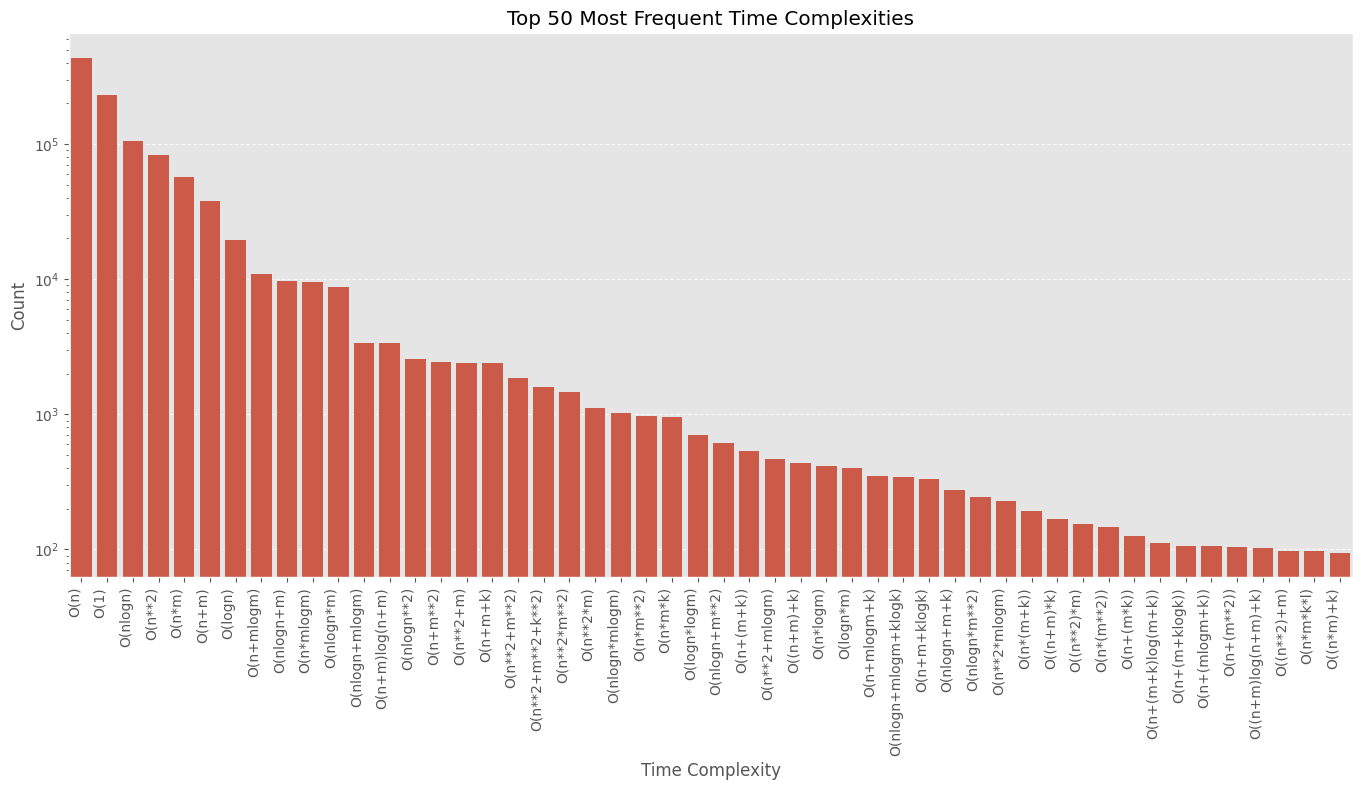

In [62]:
top_50_time_complexities = time_complexity_counts.head(50)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=top_50_time_complexities.index,
    y=top_50_time_complexities.values,
)
plt.title('Top 50 Most Frequent Time Complexities')
plt.xlabel('Time Complexity')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
# Print the most common space complexities
space_complexity_counts = df_complexity_labels_light_filtered['space_complexity_inferred'].value_counts()
print("Most common space complexities:")
print(space_complexity_counts.head(10))

Most common space complexities:
space_complexity_inferred
O(n)            537972
O(1)            294934
O(n*m)           55585
O(n**2)          37183
O(n+m)           34146
O(logn)          26314
O(nlogn)         14298
O(logn*logm)      9929
O(n+m**2)         4491
O(n**2+m)         3482
Name: count, dtype: int64


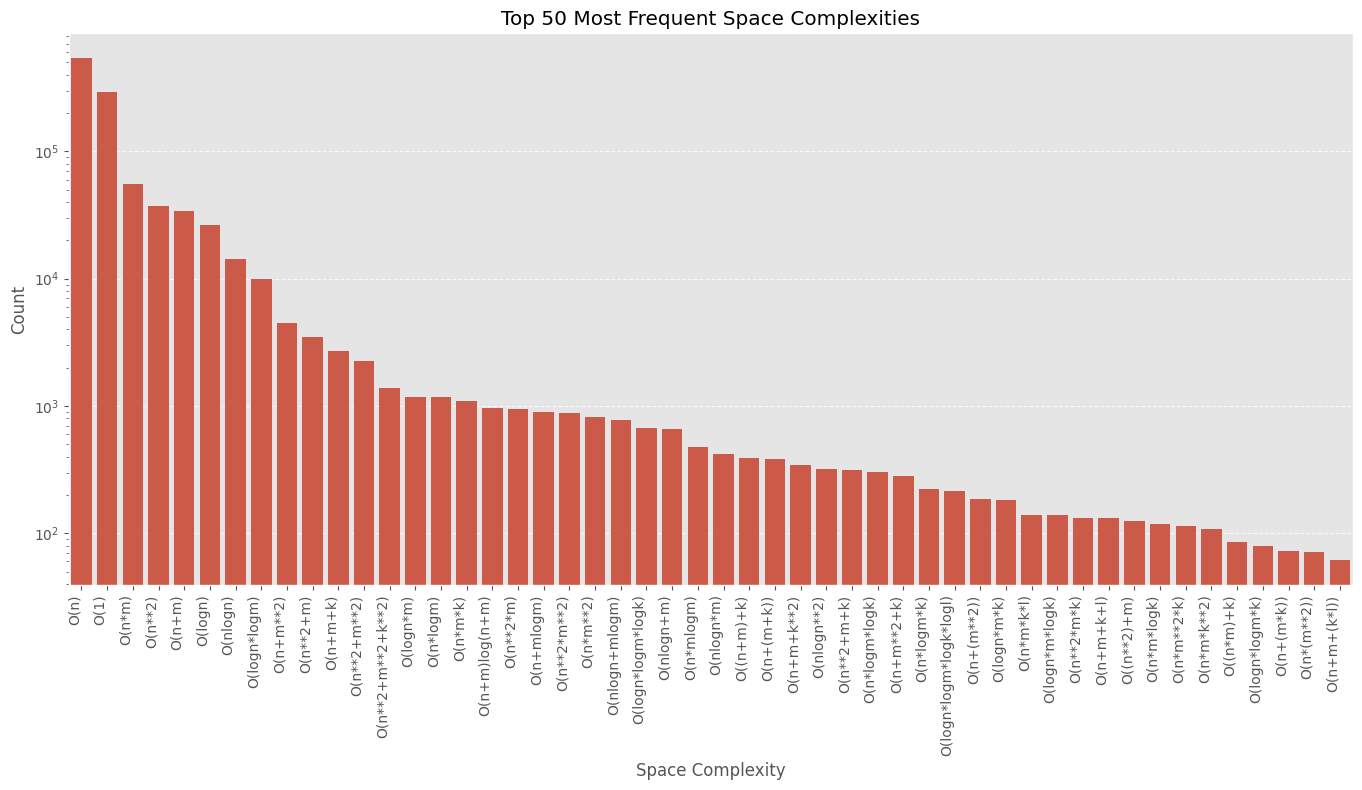

In [64]:
top_50_space_complexities = space_complexity_counts.head(50)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=top_50_space_complexities.index,
    y=top_50_space_complexities.values,
)
plt.title('Top 50 Most Frequent Space Complexities')
plt.xlabel('Space Complexity')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [65]:
# Print the most common time complexities and space complexities together
time_space_complexity_counts = df_complexity_labels_light_filtered.groupby(['time_complexity_inferred', 'space_complexity_inferred']).size().reset_index(name='counts')
time_space_complexity_counts = time_space_complexity_counts.sort_values(by='counts', ascending=False)
print("Most common time and space complexities:")
print(time_space_complexity_counts.head(10))

Most common time and space complexities:
     time_complexity_inferred space_complexity_inferred  counts
646                      O(n)                      O(n)  328719
423                      O(1)                      O(1)  174404
639                      O(n)                      O(1)   79135
2131                 O(nlogn)                      O(n)   78020
834                   O(n**2)                      O(n)   42322
1280                   O(n*m)                    O(n*m)   34980
440                      O(1)                      O(n)   25787
840                   O(n**2)                   O(n**2)   20887
424                      O(1)                   O(logn)   16652
1264                   O(n*m)                      O(n)   15444


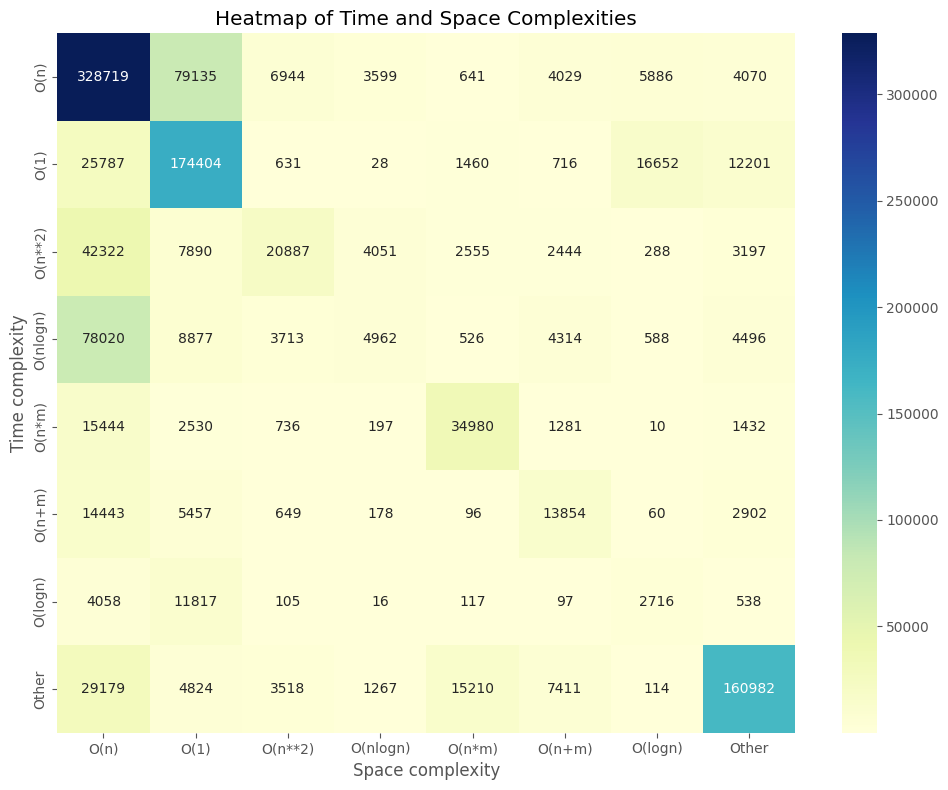

In [66]:
# Create a heatmap of time and space complexities
all_complexities = pd.concat([
    df_complexity_labels_light_filtered['time_complexity_inferred'],
    df_complexity_labels_light_filtered['space_complexity_inferred']
])
top_7_complexities = all_complexities.value_counts().head(7).index.tolist()

df_temp = df_complexity_labels_light.copy()
df_temp['time'] = df_temp['time_complexity_inferred'].apply(lambda x: x if x in top_7_complexities else 'Other')
df_temp['space'] = df_temp['space_complexity_inferred'].apply(lambda x: x if x in top_7_complexities else 'Other')

heatmap_data = df_temp.groupby(['time', 'space']).size().unstack(fill_value=0)

ordered_labels = top_7_complexities + ['Other']
heatmap_data = heatmap_data.reindex(index=ordered_labels, columns=ordered_labels, fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Time and Space Complexities")
plt.xlabel("Space complexity")
plt.ylabel("Time complexity")
plt.tight_layout()
plt.show()

In [67]:
# Total number of combinations of time and space complexities
print(f"Total number of combinations of time and space complexities:", len(time_space_complexity_counts))
# Maximum number of combinations of time and space complexities
max_combinations = time_space_complexity_counts['counts'].max()
print(f"Maximum number of combinations of time and space complexities:", max_combinations)
# Minimum number of combinations of time and space complexities
min_combinations = time_space_complexity_counts['counts'].min()
print(f"Minimum number of combinations of time and space complexities:", min_combinations)
# Average number of combinations of time and space complexities
average_combinations = time_space_complexity_counts['counts'].mean()
print(f"Average number of combinations of time and space complexities: {average_combinations:.2f}")

Total number of combinations of time and space complexities: 2612
Maximum number of combinations of time and space complexities: 328719
Minimum number of combinations of time and space complexities: 1
Average number of combinations of time and space complexities: 398.77


## CodeForces Tags

In [68]:
def extract_cf_tags(metadata):
    if isinstance(metadata, dict):
        return metadata.get('cf_tags', [])
    return []

# Count the number of unique CF tags
cf_tags_counts = df_problem_and_human_solutions_list_filtered['codeforces_specific_metadata'].apply(extract_cf_tags).explode().value_counts()
cf_tags = cf_tags_counts.index.tolist()
print("Number of unique CF tags:", len(cf_tags_counts))
print("CF tags:", cf_tags)

Number of unique CF tags: 37
CF tags: ['implementation', 'math', 'greedy', '', 'brute force', 'constructive algorithms', 'sortings', 'dp', 'strings', 'number theory', 'binary search', 'data structures', 'two pointers', 'combinatorics', 'graphs', 'dfs and similar', 'geometry', 'bitmasks', '*special', 'trees', 'games', 'dsu', 'shortest paths', 'hashing', 'divide and conquer', 'probabilities', 'expression parsing', 'ternary search', 'matrices', 'string suffix structures', 'meet-in-the-middle', 'flows', 'graph matchings', 'fft', 'schedules', 'chinese remainder theorem', '2-sat']


In [69]:
# Print number of empty CF tags
empty_cf_tags = cf_tags_counts[cf_tags_counts.index == ''].sum()
print("Number of empty CF tags:", empty_cf_tags)
# Substitue empty CF tags with 'Not defined'
cf_tags_counts = df_problem_and_human_solutions_list_filtered['codeforces_specific_metadata'].apply(extract_cf_tags).explode().replace('', 'Not defined').value_counts()
cf_tags = cf_tags_counts.index.tolist()
print("CF tags:", cf_tags)

Number of empty CF tags: 710
CF tags: ['implementation', 'math', 'greedy', 'Not defined', 'brute force', 'constructive algorithms', 'sortings', 'dp', 'strings', 'number theory', 'binary search', 'data structures', 'two pointers', 'combinatorics', 'graphs', 'dfs and similar', 'geometry', 'bitmasks', '*special', 'trees', 'games', 'dsu', 'shortest paths', 'hashing', 'divide and conquer', 'probabilities', 'expression parsing', 'ternary search', 'matrices', 'string suffix structures', 'meet-in-the-middle', 'flows', 'graph matchings', 'fft', 'schedules', 'chinese remainder theorem', '2-sat']


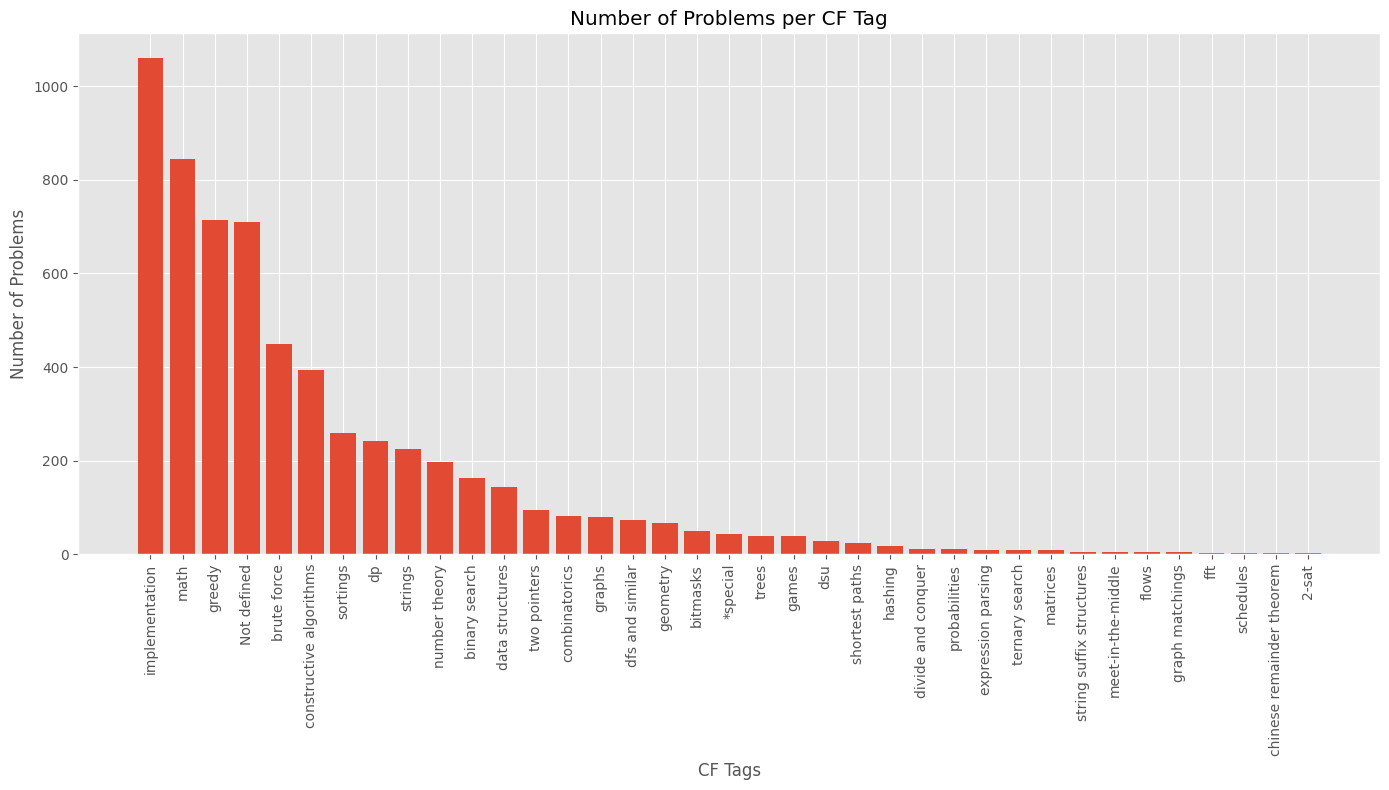

In [70]:
# Plot for each tag the number of problems
plt.figure(figsize=(14, 8))
plt.bar(cf_tags_counts.index, cf_tags_counts.values)
plt.title('Number of Problems per CF Tag')
plt.xlabel('CF Tags')
plt.ylabel('Number of Problems')
plt.xticks(rotation=90, ha='center')
plt.tight_layout() 
plt.show()

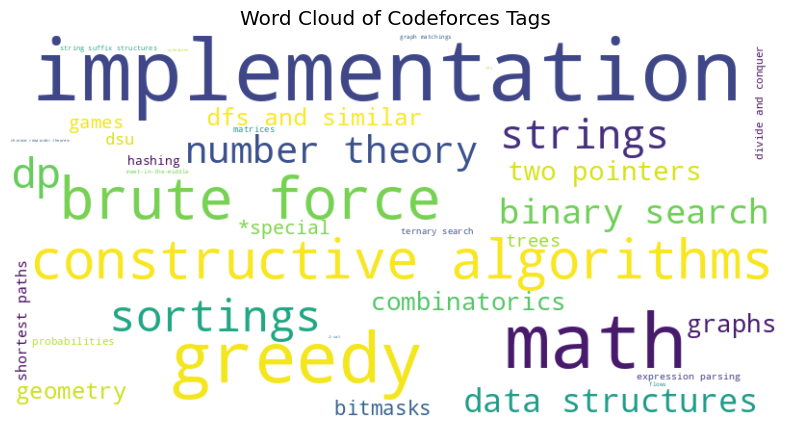

In [71]:
# Create a word cloud of cf_tags in codeforces_specific_metadata column
cf_tags_list = df_problem_and_human_solutions_list_filtered['codeforces_specific_metadata'].apply(extract_cf_tags).explode().dropna()
cf_tags_counter = Counter(cf_tags_list)
worldcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cf_tags_counter)
plt.figure(figsize=(10, 5))
plt.imshow(worldcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Codeforces Tags")
plt.show()

# Indexing and Search


We can use the text descriptions of the problems to create an index for searching similar problems.

In [ ]:
import pyterrier as pt
pt.init()


In the following cell the dataset is prepared in order to be ready to work on it according to the python-terrier library input requirements.

In [82]:
descriptions = df_problem_and_human_solutions_list_filtered['description'].dropna().tolist()
texts = [desc.get('text', '') for desc in descriptions]
df_texts = pd.DataFrame(
    [
        ['d'+str(i+1), text] for i, text in enumerate(texts)
    ],
    columns=['docno', 'text']
)
df_texts.head()

,docno,text
0,d1,Xenia has a set of weights and pan scales. Eac...
1,d2,On a strip of land of length n there are k air...
2,d3,Manao has invented a new mathematical term — a...
3,d4,"You have r red, g green and b blue balloons. T..."
4,d5,This is yet another problem dealing with regul...


The first step is to index the whole dataset.

In [ ]:
indexer = pt.DFIndexer("./index_contexts", overwrite=True)
index_ref = indexer.index(df_texts['text'], df_texts['docno'])
index_ref.toString()

In [ ]:
!ls -lh index_contexts/

total 2960
-rw-r--r--  1 chiaranguyen  staff   195K May  2 08:50 data.direct.bf
-rw-r--r--  1 chiaranguyen  staff    50K May  2 08:50 data.document.fsarrayfile
-rw-r--r--  1 chiaranguyen  staff   190K May  2 08:50 data.inverted.bf
-rw-r--r--  1 chiaranguyen  staff   779K May  2 08:50 data.lexicon.fsomapfile
-rw-r--r--  1 chiaranguyen  staff   1.0K May  2 08:50 data.lexicon.fsomaphash
-rw-r--r--  1 chiaranguyen  staff    36K May  2 08:50 data.lexicon.fsomapid
-rw-r--r--  1 chiaranguyen  staff    59K May  2 08:50 data.meta-0.fsomapfile
-rw-r--r--  1 chiaranguyen  staff    24K May  2 08:50 data.meta.idx
-rw-r--r--  1 chiaranguyen  staff    61K May  2 08:50 data.meta.zdata
-rw-r--r--  1 chiaranguyen  staff   4.1K May  2 08:50 data.properties


We print some information about the index, like the number of documents and the number of terms in the index.

In [ ]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 3014
Number of terms: 9281
Number of postings: 171024
Number of fields: 0
Number of tokens: 414933
Field names: []
Positions:   false



We print for each term some statistics, like:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences of term in corpus.
 - `maxTF` is the maximum number of occurrences of a term in a single document.

In [ ]:
for kv in index.getLexicon(): #kv is a key-value pair
    print(kv.getKey(),": ", kv.getValue().toString())

0 :  term84 Nt=1396 TF=6010 maxTF=237 @{0 0 0}
00 :  term506 Nt=34 TF=68 maxTF=5 @{0 1170 0}
000 :  term716 Nt=275 TF=463 maxTF=9 @{0 1228 4}
0001 :  term2862 Nt=2 TF=2 maxTF=1 @{0 1490 2}
001 :  term3620 Nt=11 TF=16 maxTF=3 @{0 1494 6}
0010 :  term2864 Nt=4 TF=6 maxTF=3 @{0 1517 3}
0011 :  term1047 Nt=10 TF=15 maxTF=2 @{0 1526 3}
002 :  term6141 Nt=1 TF=1 maxTF=1 @{0 1547 4}
0020 :  term6139 Nt=1 TF=1 maxTF=1 @{0 1550 2}
0024 :  term729 Nt=1 TF=1 maxTF=1 @{0 1553 0}
006 :  term4641 Nt=1 TF=1 maxTF=1 @{0 1554 4}
007 :  term4812 Nt=8 TF=13 maxTF=2 @{0 1557 0}
0079 :  term6819 Nt=1 TF=2 maxTF=2 @{0 1572 3}
01 :  term1230 Nt=29 TF=56 maxTF=6 @{0 1575 2}
010 :  term3459 Nt=15 TF=24 maxTF=4 @{0 1625 7}
0100 :  term4798 Nt=2 TF=2 maxTF=1 @{0 1654 4}
0101 :  term568 Nt=13 TF=17 maxTF=3 @{0 1659 4}
011 :  term2248 Nt=9 TF=11 maxTF=2 @{0 1683 2}
0110 :  term566 Nt=10 TF=12 maxTF=2 @{0 1702 2}
0111 :  term2865 Nt=4 TF=5 maxTF=2 @{0 1719 4}
0112 :  term6250 Nt=1 TF=1 maxTF=1 @{0 1729 1}
012 :  te

For example, the term 'sort' occurs in 81 documents, with a total of 224 occurrences, and the maximum number of occurrences in a single document is 14.

In [ ]:
index.getLexicon()['sort'].toString()

'term1036 Nt=81 TF=224 maxTF=14 @{0 164384 7}'

We can see also how many times the word 'sort' is used in each context that it occurs in. It's reported also the length of each context.

In [ ]:
pointer = index.getLexicon()["sort"]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

ID(62) TF(4) doclen = 187
ID(66) TF(2) doclen = 190
ID(68) TF(4) doclen = 93
ID(107) TF(1) doclen = 76
ID(138) TF(1) doclen = 56
ID(188) TF(1) doclen = 71
ID(196) TF(3) doclen = 106
ID(217) TF(2) doclen = 131
ID(240) TF(1) doclen = 109
ID(326) TF(2) doclen = 24
ID(340) TF(8) doclen = 104
ID(360) TF(4) doclen = 286
ID(422) TF(2) doclen = 57
ID(438) TF(2) doclen = 202
ID(443) TF(1) doclen = 187
ID(533) TF(2) doclen = 59
ID(604) TF(1) doclen = 100
ID(668) TF(4) doclen = 234
ID(676) TF(2) doclen = 324
ID(685) TF(1) doclen = 190
ID(733) TF(2) doclen = 136
ID(762) TF(2) doclen = 96
ID(767) TF(2) doclen = 173
ID(868) TF(1) doclen = 184
ID(896) TF(6) doclen = 202
ID(975) TF(1) doclen = 184
ID(1001) TF(3) doclen = 95
ID(1023) TF(3) doclen = 112
ID(1036) TF(2) doclen = 106
ID(1040) TF(13) doclen = 164
ID(1055) TF(9) doclen = 298
ID(1060) TF(1) doclen = 175
ID(1127) TF(8) doclen = 149
ID(1202) TF(1) doclen = 248
ID(1205) TF(4) doclen = 158
ID(1227) TF(2) doclen = 95
ID(1293) TF(3) doclen = 174
ID

### TF-IDF Index Search
We can use the TF-IDF index to search for similar problems. 

In [ ]:
query = "How can I sort an array"

br = pt.BatchRetrieve(index, wmodel="TF_IDF")
br.search(query)

/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/1621297601.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index, wmodel="TF_IDF")


,qid,docid,docno,rank,score,query
0,1,1040,d1041,0,10.952940,How can I sort an array
1,1,1127,d1128,1,10.699319,How can I sort an array
2,1,340,d341,2,10.362748,How can I sort an array
3,1,2715,d2716,3,10.146678,How can I sort an array
4,1,1713,d1714,4,9.917983,How can I sort an array
...,...,...,...,...,...,...
995,1,5,d6,995,1.140711,How can I sort an array
996,1,984,d985,996,1.140711,How can I sort an array
997,1,2320,d2321,997,1.140711,How can I sort an array
998,1,2421,d2422,998,1.140711,How can I sort an array


In [ ]:
most_relevant_result = df_texts.loc[df_texts['docno'] == 'd1041', 'text'].values[0]
print(most_relevant_result)

[Thanos sort](https://codegolf.stackexchange.com/questions/182221/implement-the-thanos-sorting-algorithm) is a supervillain sorting algorithm, which works as follows: if the array is not sorted, snap your fingers* to remove the first or the second half of the items, and repeat the process.

Given an input array, what is the size of the longest sorted array you can obtain from it using Thanos sort?

*Infinity Gauntlet required.

Input

The first line of input contains a single number n (1 ≤ n ≤ 16) — the size of the array. n is guaranteed to be a power of 2.

The second line of input contains n space-separated integers a_i (1 ≤ a_i ≤ 100) — the elements of the array.

Output

Return the maximal length of a sorted array you can obtain using Thanos sort. The elements of the array have to be sorted in non-decreasing order.

Examples

Input


4
1 2 2 4


Output


4


Input


8
11 12 1 2 13 14 3 4


Output


2


Input


4
7 6 5 4


Output


1

Note

In the first example the array is already 

In [ ]:
queries = pd.DataFrame([["query1", "list"], ["query2", "highest"], ["query3", "number"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,2805,d2806,0,5.147456,list
1,query1,2389,d2390,1,5.042130,list
2,query1,1018,d1019,2,4.963281,list
3,query1,240,d241,3,4.934484,list
4,query1,2613,d2614,4,4.906904,list
...,...,...,...,...,...,...
1143,query3,246,d247,995,1.041843,number
1144,query3,233,d234,996,1.040734,number
1145,query3,553,d554,997,1.040734,number
1146,query3,2984,d2985,998,1.040734,number


In [ ]:
most_relevant_result = df_texts.loc[df_texts['docno'] == 'd2806', 'text'].values[0]
print(most_relevant_result)

Two players A and B have a list of n integers each. They both want to maximize the subtraction between their score and their opponent's score. 

In one turn, a player can either add to his score any element from his list (assuming his list is not empty), the element is removed from the list afterward. Or remove an element from his opponent's list (assuming his opponent's list is not empty).

Note, that in case there are equal elements in the list only one of them will be affected in the operations above. For example, if there are elements \{1, 2, 2, 3\} in a list and you decided to choose 2 for the next turn, only a single instance of 2 will be deleted (and added to the score, if necessary). 

The player A starts the game and the game stops when both lists are empty. Find the difference between A's score and B's score at the end of the game, if both of the players are playing optimally.

Optimal play between two players means that both players choose the best possible strategy to achie

### BM25 Index Search
We perform the same search using the BM25 index to see if there are any differences in the results.

In [ ]:
query = "How can I sort an array"

br = pt.BatchRetrieve(index, wmodel="BM25")
br.search(query)

/var/folders/_p/_zv9pcfx0h9b_ltd79hhdgr00000gn/T/ipykernel_37542/2031488563.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(index, wmodel="BM25")


,qid,docid,docno,rank,score,query
0,1,1040,d1041,0,16.281132,How can I sort an array
1,1,340,d341,1,16.221999,How can I sort an array
2,1,1127,d1128,2,15.993463,How can I sort an array
3,1,2715,d2716,3,15.403267,How can I sort an array
4,1,2124,d2125,4,15.359915,How can I sort an array
...,...,...,...,...,...,...
995,1,1364,d1365,995,-0.625698,How can I sort an array
996,1,1478,d1479,996,-0.625698,How can I sort an array
997,1,2155,d2156,997,-0.626064,How can I sort an array
998,1,2897,d2898,998,-0.626935,How can I sort an array


In [ ]:
queries = pd.DataFrame([["query1", "list"], ["query2", "highest"], ["query3", "number"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,2805,d2806,0,9.195029,list
1,query1,2389,d2390,1,9.006882,list
2,query1,1018,d1019,2,8.866031,list
3,query1,240,d241,3,8.814590,list
4,query1,2613,d2614,4,8.765324,list
...,...,...,...,...,...,...
1143,query3,768,d769,995,-2.753890,number
1144,query3,1036,d1037,996,-2.753890,number
1145,query3,1410,d1411,997,-2.753890,number
1146,query3,1430,d1431,998,-2.753890,number


In [ ]:
lexicon = index.getLexicon()
term_frequencies = []

for kv in lexicon:
    term_frequencies.append(kv.getValue().getDocumentFrequency())

plt.figure(figsize=(10,6))
plt.hist(term_frequencies, bins=100, log=True)
plt.title("Distribuzione Document Frequency dei Termini")
plt.xlabel("Document Frequency")
plt.ylabel("Numero di Termini (log scale)")
plt.show()

## Problem Name

In [90]:
# Clean the problem names
problem_name_counts = df_problem_and_human_solutions_list_filtered['problem_name'].apply(
    lambda x: ' '.join(x.split(' ')[1:]) if ' ' in x else x
).value_counts()

# Count the number of duplicate problem names
duplicate_problem_names = problem_name_counts[problem_name_counts > 1]

print("Number of unique clean problem names:", len(problem_name_counts))
print("Number of duplicated clean problem names:", len(duplicate_problem_names))
print("Duplicated problem names:")
print(duplicate_problem_names[duplicate_problem_names > 1].index.tolist())

Number of unique clean problem names: 2891
Number of duplicated clean problem names: 111
Duplicated problem names:
['Queue', 'Exams', 'Make Them Equal', 'Cards', 'Game', 'Coins', 'Card Game', 'Phone Numbers', 'Candies', 'Triangle', 'k-Amazing Numbers', 'Pythagorean Triples', 'Common Divisors', 'Drazil and His Happy Friends', 'Divisibility', 'Quiz', 'Dreamoon and Sums', 'Rectangle', 'Plus and Square Root', 'Vacations', "Mr. Kitayuta's Gift", 'Tennis Championship', 'Suit and Tie', 'Lucky Numbers', 'Little Artem and Grasshopper', 'Permutation', 'Treasure Hunt', 'Division', 'Connect Three', 'Appleman and Toastman', 'Special Permutation', "Hilbert's Hotel", 'Linova and Kingdom', 'Chain Reaction', 'Extreme Subtraction', 'Prefix Sum Primes', 'Binary String Reconstruction', 'Multiplication Table', 'Photo of The Sky', 'Drazil and Factorial', 'Save Energy!', 'Boxes Packing', 'Domino for Young', 'Oh Those Palindromes', 'Long Beautiful Integer', 'Watchmen', 'Aerodynamic', 'Fox And Names', "Gerald'

In [91]:
# Drop data_source column
df_problem_and_human_solutions_list = df_problem_and_human_solutions_list.drop(columns=['data_source'])

In [92]:
# Drop source_specific_limits column
df_problem_and_human_solutions_list = df_problem_and_human_solutions_list.drop(columns=['source_specific_limits'])

# Word Embedding Analysis

## Initialization

Import all the required libraries used for the Word Embedding part.

In [5]:
# Load additional libraries for visualization and text processing
import json
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import string
import re
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import collections
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist

regex_punctuation = '[' + string.punctuation + ']'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
# Just a recap of the main dataframe
df_problem_and_human_solutions_list.head()

,problem_id,problem_name,description,correct_solution_list,codeforces_specific_metadata,tests,human_accuracy_rate,dataclass,complexity_framework
0,0,339_C. Xenia and Weights,Xenia has a set of weights and pan scales. Eac...,"[{'solution_id': '0_0', 'solution_code': '__au...","{'cf_contest_id': 339, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '0000000101 3 ', '...",0.281633,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.40579710144927...
1,1,1547_E. Air Conditioners,On a strip of land of length n there are k air...,"[{'solution_id': '1_0', 'solution_code': 'def ...","{'cf_contest_id': 1547, 'cf_index': 'E', 'cf_p...",{'public_tests': [{'input': '5 6 2 2 5 14 16 ...,0.620833,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.11409395973154...
2,2,268_C. Beautiful Sets of Points,Manao has invented a new mathematical term — a...,"[{'solution_id': '2_0', 'solution_code': 'if _...","{'cf_contest_id': 268, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '2 2 ', 'output': ...",0.525066,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.05527638190954...
3,3,478_C. Table Decorations,"You have r red, g green and b blue balloons. T...","[{'solution_id': '3_0', 'solution_code': 'a = ...","{'cf_contest_id': 478, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '1 1 1 ', 'output'...",0.562264,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.41610738255033...
4,4,5_C. Longest Regular Bracket Sequence,This is yet another problem dealing with regul...,"[{'solution_id': '4_0', 'solution_code': 'stri...","{'cf_contest_id': 5, 'cf_index': 'C', 'cf_poin...","{'public_tests': [{'input': ')((())))(()()) ',...",0.395939,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.03846153846153...


In [ ]:
#use if running the notbook locally
'''# Remove from description is_description_translated and untranslated_text
def remove_untranslated_text(description):
    if isinstance(description, dict):
        description.pop('is_description_translated', None)
        description.pop('untranslated_text', None)
    return description

df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(remove_untranslated_text)'''

In [ ]:
# use if running the notebook locally
'''# Remove dict in description and keep only the text
def extract_text_from_description(description):
    if isinstance(description, dict):
        return description.get('text', '')
    return description

df_problem_and_human_solutions_list['description'] = df_problem_and_human_solutions_list['description'].apply(extract_text_from_description)'''

In [97]:
# Make a working copy of the dataframe and extract non-empty descriptions
df_problem_and_human_solutions_list_we = df_problem_and_human_solutions_list.copy()
descriptions= df_problem_and_human_solutions_list_we['description'].dropna()

# Print the first 10 cleaned descriptions
print(descriptions[0:10])

0    Xenia has a set of weights and pan scales. Eac...
1    On a strip of land of length n there are k air...
2    Manao has invented a new mathematical term — a...
3    You have r red, g green and b blue balloons. T...
4    This is yet another problem dealing with regul...
5    Consider the infinite sequence of integers: 1,...
6    Let's introduce a number system which is based...
7    A few years ago Sajjad left his school and reg...
8    Polycarp likes to play with numbers. He takes ...
9    There are N people standing in a queue from we...
Name: description, dtype: object


## Sentence Tokenization

We now split the cleaned descriptions into individual sentences.  
This allows more fine-grained analysis and better context modeling when training word embeddings later.

In [22]:
# Replace newline characters with space and split by punctuation to get sentences
descriptions= [re.sub(r'\n', ' ', description) for description in descriptions]
descriptions_sentences = [re.split(r'[.!?]\s', description) for description in descriptions]

# Show the first description devided in sentences
descriptions_sentences[0]

['Xenia has a set of weights and pan scales',
 'Each weight has an integer weight from 1 to 10 kilos',
 'Xenia is going to play with scales and weights a little',
 'For this, she puts weights on the scalepans, one by one',
 'The first weight goes on the left scalepan, the second weight goes on the right scalepan, the third one goes on the left scalepan, the fourth one goes on the right scalepan and so on',
 'Xenia wants to put the total of m weights on the scalepans',
 ' Simply putting weights on the scales is not interesting, so Xenia has set some rules',
 'First, she does not put on the scales two consecutive weights of the same weight',
 'That is, the weight that goes i-th should be different from the (i + 1)-th weight for any i (1 ≤ i < m)',
 'Second, every time Xenia puts a weight on some scalepan, she wants this scalepan to outweigh the other one',
 'That is, the sum of the weights on the corresponding scalepan must be strictly greater than the sum on the other pan',
 ' You are g

In [102]:
from pandas.core.common import flatten

# Flatten the list of lists into a single list of sentences
sentences = list(flatten(descriptions_sentences))

# Show the first 30 sentences of the all descriptions corpus
sentences[0:30]

['Xenia has a set of weights and pan scales',
 'Each weight has an integer weight from 1 to 10 kilos',
 'Xenia is going to play with scales and weights a little',
 'For this, she puts weights on the scalepans, one by one',
 'The first weight goes on the left scalepan, the second weight goes on the right scalepan, the third one goes on the left scalepan, the fourth one goes on the right scalepan and so on',
 'Xenia wants to put the total of m weights on the scalepans',
 ' Simply putting weights on the scales is not interesting, so Xenia has set some rules',
 'First, she does not put on the scales two consecutive weights of the same weight',
 'That is, the weight that goes i-th should be different from the (i + 1)-th weight for any i (1 ≤ i < m)',
 'Second, every time Xenia puts a weight on some scalepan, she wants this scalepan to outweigh the other one',
 'That is, the sum of the weights on the corresponding scalepan must be strictly greater than the sum on the other pan',
 ' You are g

In [103]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [23]:
import spacy
from gensim.models import Word2Vec
from typing import List
from nltk.corpus import stopwords
import pickle

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Custom stopword list (exclude important programming-related words)
custom_stopwords = set(stopwords.words('english')) - {
    'if', 'for', 'while', 'function', 'input', 'output', 'return', 'else', 'and', 'or','not','each','all','any','to',
    'not', 'in', 'is', 'as', 'def', 'import', 'from', 'class', 'with', 'try', 'except',
    'i', 'j', 'k', 'x', 'y', 'z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'l', 'm', 'n',
    's', 't', 'u', 'v', 'w', 'p', 'q', 'r', 'yes', 'no', 'true', 'false',
}
custom_stopwords = set([word.lower() for word in custom_stopwords])

# Define mapping of Unicode math/symbol characters to ASCII equivalents
UNICODE_SYMBOLS = {
    '≤': '<=',
    '≥': '>=',
    '≠': '!=',
    '→': '->',
    '←': '<-',
    '⋅': '*',
    '×': '*',
    '÷': '/',
    '−': '-',
    '“': '"',
    '”': '"',
    '‘': "'",
    '’': "'"
}

def normalize_unicode_symbols(text: str) -> str:
    for uni_char, ascii_equiv in UNICODE_SYMBOLS.items():
        text = text.replace(uni_char, f' {ascii_equiv} ')
    return text

# Replace complex numbers with labeled placeholders.
def substitute_special_numbers(text: str) -> str:
    # Replace scientific notation (e.g., 1e9, -2.5E-10)
    text = re.sub(r"\b-?\d+(\.\d+)?[eE][+-]?\d+\b", " sci_num ", text)
    # Replace decimal numbers (e.g., 3.14, -0.5)
    text = re.sub(r"\b-?\d+\.\d+\b", " float_num ", text)
    # Replace exponent notation (e.g., 10^5)
    text = re.sub(r"\b\d+\^\d+\b", " exp_num ", text)
    # Replace fractions (e.g., 3/4)
    text = re.sub(r"\b-?\d+/\d+\b", " frac_num ", text)
    # Replace integers (keep this last to not override previous ones)
    text = re.sub(r"\b-?\d+\b", " int_num ", text)
    return text

Tokenizes and preprocesses technical sentences while preserving structural elements such as function calls, array indexing, and variable names.  
This helps maintain the syntactic and semantic integrity of programming-related expressions.

In [24]:

def custom_tokenize(sentence: str) -> List[str]:
    
    # 1. Lowercase
    sentence = sentence.lower()
    
    # 2.Normalize Unicode symbols (e.g., ≤, ≥, →) to ASCII equivalents
    sentence = normalize_unicode_symbols(sentence)

    # 3. Preserve important math/programming symbols (remove others)
    # Keep: +, -, *, /, =, <, >, [, ], (, ), ., _, ,, |, ^ numbers and letters
    sentence = re.sub(r"[^\w\s\[\]\(\)\+\-\*/=<>.,\{\}\|\^]", "", sentence)

    # 4. Replace complex numbers and other refnements BEFORE spaCy tokenization
    sentence = substitute_special_numbers(sentence)

    # Remove repeted '.' (e.g., "....")
    sentence = re.sub(r"\.{2,}", " ", sentence)

    # Remove very unuseful long words
    sentence = re.sub(r"\b\w{21,}\b", " ", sentence)  
    
    # Remove words with repeated characters (e.g., "aaaaabbb")
    # maybe useful for some cases, but not for all
    # sentence = re.sub(r"\b(\w*([a-zA-Z])\2{4,}\w*)\b", " ", sentence)

    # 5. Separate symbols with space to treat them as separate tokens
    # E.g., f(x) → f ( x ), arr[2] → arr [ 2 ]
    sentence = re.sub(r"([\[\]\(\)\+\-\*/=.,\{\}\|])", r" \1 ", sentence)

    # Remove extra spaces (e.g., "  f ( x )  " → "f ( x )")
    sentence = re.sub(r"\s+", " ", sentence) 

    # 6. Tokenize using spaCy (preserves useful structures)
    doc = nlp(sentence)
    tokens = []

    for token in doc:
        # Skip punctuation and unwanted stopwords (unless technical)
        if token.text in custom_stopwords or token.is_space:
            continue

        # Lemmatize token using spaCy
        lemma = token.lemma_.lower()

        # Optional: normalize common variable names (e.g., a_1, res, val)
        if re.fullmatch(r"[a-zA-Z_]+\d*", lemma):
            # You can optionally map them to <var> or leave them
            tokens.append(lemma)# put here '<var>' if you want to normalize them
        else:
            tokens.append(lemma)
    return tokens

Here, there are some examples to test the tokenizer behavior and some possible edge cases.

In [25]:
# Example input: technical sentences with variables, functions, arrays...
sentences_trial = [
    "The function f(x) = x^2 + 10000000000000000000000000000, define f(x) as x * x + 1 to 100",
    "The function f(x) = x^2 + sjndjncjd0000000000000000000000000, define f(x) as x * x + 1 nskkk^^^^^sk1 naallloooonnn ... .. .... kk lll_test",
    "The function f(x) returns x * x + 1",
    "Use arr[0] and arr[1] to store the inputs.",
    "Check if a_1 + b_2 == c_3.",
    "Return the result in res after the while loop.",
    "for i in range(1, 10): sum += arr[i]",
    "Initialize matrix m with zeros using numpy.zeros((3,3))",
    "inputs = [1, 2, 3]; output = f(inputs[0])",
    "Sort the array nums in ascending order.",
    "Let temp = (x + y) / 2",
    "Function g(n) = n*(n-1)/2 calculates combinations.",
    "temperature in cell 1 is: min(14 + |2 - 1|, 16 + |5 - 1|)=min(14 + 1, 16 + 4)=min(15, 20)=15;    2",
    "))(skdfksf + u) -> 0.5 * (a + b) + 1.5 * (c - d) / e; 3.14 * pi = 3.14;",
    "if (x > 0) and (y < 10): print('Valid') else: print('Invalid')",
    "while (i < 10): i += 1; print(i)",
    "from math import sqrt; result = sqrt(x**2 + y**2)",
    "def calculate_area(radius): return 3.14 * radius ** 2 * 10^17",
    "The first line contains two integers n (1 ≤ n ≤ 3 ⋅ 10^5) and k (1 ≤ k ≤ n) — the length of the strip of land and the number of air conditioners respectively'",
    "The second line contains k integers a_1, a_2, …, a_k (1 ≤ a_i ≤ n) — positions of air conditioners on the strip of land",
    "The third line contains k integers t_1, t_2, …, t_k (1 ≤ t_i ≤ 10^9) — temperatures of air conditioners",
    "It is guaranteed that the sum of n over all test cases does not exceed 3 ⋅ 10^5",
    "Output  For each test case output n integers separated by space: temperatures of air in cells",
    "Example  Input   5  6 2 2 5 14 16  10 1 7 30  5 5 3 1 4 2 5 3 1 4 2 5  7 1 1 1000000000",
    "Manao has invented a new mathematical term — a beautiful set of points",
    "Examples  Input  0000000101 3   Output  YES 8 10 8   Input  1000000000 2   Output  NO",
    "For each cell i (1 ≤ i ≤ n) find it's temperature, that can be calculated by the formula $$$min_{1 ≤ j ≤ k}(t_j + |a_j - i|),$$$  where |a_j - i| denotes absolute value of the difference a_j - i"
]

# Apply custom tokenizer
tokenized_corpus_trial= [custom_tokenize(sent) for sent in sentences_trial]

# Print tokenized output
for i, toks in enumerate(tokenized_corpus_trial):
    print(f"Sentence {i+1}: {sentences_trial[i]} \n tokens: {toks}")

Sentence 1: The function f(x) = x^2 + 10000000000000000000000000000, define f(x) as x * x + 1 to 100 
 tokens: ['function', 'f', '(', 'x', ')', '=', 'x^', 'int_num', '+', 'int_num', ',', 'define', 'f', '(', 'x', ')', 'as', 'x', '*', 'x', '+', 'int_num', 'to', 'int_num']
Sentence 2: The function f(x) = x^2 + sjndjncjd0000000000000000000000000, define f(x) as x * x + 1 nskkk^^^^^sk1 naallloooonnn ... .. .... kk lll_test 
 tokens: ['function', 'f', '(', 'x', ')', '=', 'x^', 'int_num', '+', ',', 'define', 'f', '(', 'x', ')', 'as', 'x', '*', 'x', '+', 'int_num', 'nskkk^^^^^sk1', 'naallloooonnn', 'kk', 'lll_test']
Sentence 3: The function f(x) returns x * x + 1 
 tokens: ['function', 'f', '(', 'x', ')', 'return', 'x', '*', 'x', '+', 'int_num']
Sentence 4: Use arr[0] and arr[1] to store the inputs. 
 tokens: ['use', 'arr', '[', 'int_num', ']', 'and', 'arr', '[', 'int_num', ']', 'to', 'store', 'input', '.']
Sentence 5: Check if a_1 + b_2 == c_3. 
 tokens: ['check', 'if', 'a_1', '+', 'b_2', '='

In [ ]:
# Apply custom tokenizer, skip and load from file if needed
tokenized_corpus = [custom_tokenize(sent) for sent in sentences]

Store the tokenized corpus in a pickle file for easy access later. Useful to avoid reprocessing the data every time

In [ ]:
# Save the tokenized corpus in a file
with open("tokenized_descriptions_corpus.pkl", "wb") as f:
    pickle.dump(tokenized_corpus, f)


In [109]:
# Load the tokenized corpus from the pickle file
with open("tokenized_descriptions_corpus.pkl", "rb") as f:
    tokenized_corpus = pickle.load(f)

Now we have the sentences of the real problem descriptions tokenized. 

In [110]:
# Print tokenized output
for i, toks in enumerate(tokenized_corpus):
    if i >= 20:  # Limit to first 20 sentences for brevity
        break
    # Print only the first 20 sentences for brevity
    print(f"Sentence {i+1}: {sentences[i]} \n tokens: {toks}")

Sentence 1: Xenia has a set of weights and pan scales 
 tokens: ['xenia', 'a', 'set', 'weight', 'and', 'pan', 'scale']
Sentence 2: Each weight has an integer weight from 1 to 10 kilos 
 tokens: ['each', 'weight', 'integer', 'weight', 'from', 'int_num', 'to', 'int_num', 'kilo']
Sentence 3: Xenia is going to play with scales and weights a little 
 tokens: ['xenia', 'be', 'go', 'to', 'play', 'with', 'scale', 'and', 'weight', 'a', 'little']
Sentence 4: For this, she puts weights on the scalepans, one by one 
 tokens: ['for', ',', 'put', 'weight', 'scalepans', ',', 'one', 'one']
Sentence 5: The first weight goes on the left scalepan, the second weight goes on the right scalepan, the third one goes on the left scalepan, the fourth one goes on the right scalepan and so on 
 tokens: ['first', 'weight', 'go', 'left', 'scalepan', ',', 'second', 'weight', 'go', 'right', 'scalepan', ',', 'third', 'one', 'go', 'left', 'scalepan', ',', 'fourth', 'one', 'go', 'right', 'scalepan', 'and']
Sentence 6: X

## Word2Vec

The main goal here is to train a Word2Vec model to learn the embeddings of the words of the descriptions based on the problems data.

In [ ]:
#!pip install gensim

In [ ]:
from gensim.models import Word2Vec

# Create Word2Vec model
# tokenized corpus is the list of lists of token (already created by the previous code)
w2v_model = Word2Vec(
    sentences= tokenized_corpus,
    vector_size=100,    # dmension of the word vectors
    window=5,           # context window size
    min_count=2,        # minimum frequency of words to be considered
    workers=4,          # multi-threading
    sg=1                # 1 = skip-gram, 0 = CBOW
)

# Save the model
w2v_model.save("word2vec.model")


In [111]:
# Load the model, useful to skip the previous training step
w2v_model = Word2Vec.load("word2vec.model")

In [112]:
# Vocabulary size
print("Vocabulary keys: \n",w2v_model.wv.key_to_index.keys())
print("Number of words in the vocabulary:", len(w2v_model.wv.key_to_index))

Vocabulary keys: 
 dict_keys(['int_num', ',', 'a', '=', 'be', 'in', 'and', '<', '(', ')', 'input', 'n', 'output', '-', 'number', 'integer', 'line', '*', 'first', 'contain', 'example', 'one', 'if', 'for', 'i', 'each', 'print', 'from', 'not', '+', 'second', 'all', 'b', 'with', 'string', 'two', 'give', 'case', 'x', 's', 'test', '{', '}', 'k', 'th', 'as', 'no', 'note', 'or', '.', ']', '[', 't', '>', 'exp_num', 'any', 'possible', '|', 'follow', 'length', 'm', 'single', 'leq', 'array', 'sequence', 'time', 'answer', '_', 'find', 'element', 'equal', 'value', 'letter', 'yes', 'consist', 'character', 'a_i', 'y', 'day', 'operation', 'get', 'move', 'make', 'order', 'minimum', 'c', 'want', 'point', 'j', 'choose', 'sum', 'third', 'maximum', 'sample', 'exactly', '/', 'd', 'need', 'image', 'game', 'use', 'write', 'r', 'three', 'digit', 'cell', 'way', 'problem', 'l', 'take', 'pair', 'a_1', 'next', 'positive', 'guarantee', 'position', 'constraint', 'format', 'ai', 'right', 'go', 'otherwise', 'p', 'total

In [114]:
# Print the most similar words to a given word
print("Most similar words to 'function':")
w2v_model.wv.most_similar('function', topn=10)

Most similar words to 'function':


[('numerator', 0.7565996050834656),
 ('we', 0.7453500032424927),
 ('lets', 0.7399095892906189),
 ('follows', 0.739900529384613),
 ('denominator', 0.727717399597168),
 ('f', 0.7220086455345154),
 ('euclidean', 0.7210003137588501),
 ('define', 0.7158343195915222),
 ('formula', 0.7125118970870972),
 ('irreducible', 0.7005667686462402)]

In [115]:
# Print the most similar words to a given word
print("Most similar words to 'array':")
w2v_model.wv.most_similar('array', topn=10)

Most similar words to 'array':


[('subarray', 0.7538277506828308),
 ('permutation', 0.7525390386581421),
 ('element', 0.7008444666862488),
 ('subsegment', 0.6911046504974365),
 ('multiset', 0.671673595905304),
 ('sequence', 0.6378703117370605),
 ('sorted', 0.6317214965820312),
 ('mex', 0.6302142143249512),
 ('yield', 0.6286007165908813),
 ('progression', 0.6281257271766663)]

In [116]:
# Print the most similar words to a given word
print("Most similar words to 'graph':")
w2v_model.wv.most_similar('graph', topn=10)

Most similar words to 'graph':


[('undirected', 0.8931739330291748),
 ('connected', 0.8270784616470337),
 ('edge', 0.824512243270874),
 ('rooted', 0.7907810807228088),
 ('component', 0.7904513478279114),
 ('tree', 0.776930034160614),
 ('subgraph', 0.7757490873336792),
 ('root', 0.7704923152923584),
 ('unweighted', 0.769507884979248),
 ('vertex', 0.7576366066932678)]

In [117]:
# Print the most similar words to a given word
print("Most similar words to 'matrix':")
w2v_model.wv.most_similar('matrix', topn=10)

Most similar words to 'matrix':


[('grid', 0.7598245739936829),
 ('chessboard', 0.7413293123245239),
 ('vector', 0.7187368869781494),
 ('histogram', 0.7009692788124084),
 ('board', 0.683229386806488),
 ('configuration', 0.6795511841773987),
 ('diagonal', 0.6716492772102356),
 ('table', 0.6689319610595703),
 ('column', 0.6681662201881409),
 ('numbering', 0.6663357615470886)]

Word2Vec is a static model that is not able to retrieve the embedding for unknown tokens that are not in the vocabulary.

In [118]:
# Print the most similar words to a given word that is not in the vocabulary of the model
if(w2v_model.wv.key_to_index.get('c++') is not None):
    w2v_model.wv.most_similar('c++', topn=10)
else:
    print("'c++' not in vocabulary of Word2Vec model")

'c++' not in vocabulary of Word2Vec model


In [120]:
#!pip install -U scikit-learn
#!pip install plotly

In [119]:
import random

# Sample 500 words from the vocabulary
# This is useful to avoid printing too many words
sample = random.sample(list(w2v_model.wv.key_to_index), 500)
print(sample)

['sportsman', 'ddddd', 'harshad', 'expectation', 'zzz', 'delimiter', 'r_j', 'p4', 'legendary', 'minibus', 'increment', 'explicit', '1a_i', 'requirement', 'bracketed', 'lantern', 'lamp', 'boyfriend', 'barrier', 'unable', 'actor', 'vus', 'origin', 'winter', 'original', 'bb', 'dimension', 'g', '2', 'campus', 'entirely', 'towards', 'proof', 'article', 'fractional', 'c_d', 'lock', '0s', 'abbaxyzyx', 'hade', 'cerene', 'main', 'creation', 'mafia', 'dominos', 'sweetheart', 'song', 'superhero', 'heihachi', 'outdate', 'clash', '100b', 'allowance', 'editor', 'bj', 'teacher', 'dominant', 'rn', 'qaj', 'secondly', 'serejas', 'seller', 'extraterrestrial', 'ensure', 'representative', 'maxdigit', 'respect', 'ambiguity', 'w', 'luke', 'z_b', 'cipher', 'message_text', 'stair', 'p_1', 'lake', 'becomes', 'mahjong', 'incorrect', 'easter', 'ababacac', 'scary', 'vika', 'ivan', 'dividing', 'andrewid', 'dima', 'x2', 'insist', 'a2', 'thinking', 'baacb', 'firmly', 'bbba', 'terminal', '4d', 'proportionally', 'newly

In [121]:
# Print the word vectors for the sampled words
word_vectors = w2v_model.wv[sample]
print(word_vectors)
print("Shape of word vectors:", word_vectors.shape)

[[-0.11936899  0.10299071  0.03433236 ... -0.03352115 -0.04247646
   0.02753926]
 [-0.17219798  0.09191184  0.0801812  ... -0.20818864 -0.00262245
   0.18203168]
 [-0.12350684  0.14484428 -0.08046809 ... -0.11296638  0.02065219
   0.05273551]
 ...
 [-0.11349777  0.09550416  0.01468306 ... -0.09879068 -0.03565263
   0.0020157 ]
 [-0.31487083  0.19803263  0.1703525  ... -0.19807343 -0.2636297
   0.00632137]
 [-0.20205177  0.21558926  0.00650744 ... -0.25863162 -0.09012631
   0.26258966]]
Shape of word vectors: (500, 100)


In [122]:
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px

# Perform t-SNE to reduce the dimensionality of the word vectors to 3D
# This is useful to visualize the word vectors in 3D space
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

# Extract x, y, z coordinates from the t-SNE embedding
x, y, z = np.transpose(tsne_embedding)

# Plot the 3D scatter plot using Plotly
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()


c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Plots the words most similar to a given set of reference words using a FastText or Word2Vec model.

Parameters:
- model (gensim model): The trained FastText or Word2Vec model.
- centers (list of str): List of reference words for which to find and visualize the most similar words.

In [123]:

def plot_word_embedding_grouped(model, centers):
    
    labels = []
    words = []
    for center in centers:
        try:
            # Get the most similar words to the center word
            similar_words = [w[0] for w in model.wv.most_similar(center, topn=15)]
            # Add the center word to the list of similar words
            similar_words.append(center)
    
            for word in similar_words:
                if word not in words:
                    words.append(word)
                    labels.append(center)
        except KeyError:
            print(f"Word '{center}' not in vocabulary.")

    # Extract the vectors form the words
    vectors = np.array([model.wv[word] for word in words])

    # Apply t-SNE to reduce the dimensionality of the word vectors to 3D
    tsne = TSNE(n_components=3, n_iter=2000, perplexity=10, init='random', random_state=42)
    tsne_embedding = tsne.fit_transform(vectors)
    x, y, z = np.transpose(tsne_embedding)

    # Create a DataFrame for Plotly
    df = pd.DataFrame({
        'x': x,
        'y': y,
        'z': z,
        'word': words,
        'group': labels
    })

    # Visualize the 3D scatter plot using Plotly
    fig = px.scatter_3d(
        df,
        x='x',
        y='y',
        z='z',
        text='word',
        color='group',
        title='3D t-SNE Word Embedding Visualization (Grouped)'
    )

    fig.update_traces(marker=dict(size=5, line=dict(width=2)), textfont_size=10)
    fig.show()

In [125]:
# Plotting example
centers=["sort", "search", "delete", "graph", "c++"]
plot_word_embedding_grouped(w2v_model, centers)

Word 'c++' not in vocabulary.


c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



## FastText

The main goal here is to train a FastText model to learn the embeddings of the words of the descriptions based on data or on pretrained models.

### Pretrained FastText Model

In [126]:
#!pip install fasttext-wheel
#import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft_model_pretrained= fasttext.load_model('cc.en.300.bin')

Load the pre-trained FastText model
Note: You need to download the pre-trained model from the FastText website and provide the path to the model file  
You can download the english bin model from https://fasttext.cc/docs/en/crawl-vectors.html

In [ ]:
import fasttext

ft_model_pretrained = fasttext.load_model("cc.en.300.bin")

In [ ]:
# Obtain the n most similar words to a word
similar_words = ft_model_pretrained.get_nearest_neighbors("function", k=10)

# Print the most similar words
for similarity, word in similar_words:
    print(f"{word}: {similarity:.4f}")

functions: 0.8180
funtion: 0.7658
funciton: 0.7439
fuction: 0.7246
fucntion: 0.7213
function.The: 0.7023
function.: 0.7003
fucntions: 0.6737
function.This: 0.6610
fuctions: 0.6517


In [ ]:
# Obtain the n most similar words to a word
similar_words = ft_model_pretrained.get_nearest_neighbors("graph", k=10)
# Print the most similar words
for similarity, word in similar_words:
    print(f"{word}: {similarity:.4f}")

graphs: 0.8243
graph.: 0.7100
graphed: 0.7057
scatterplot: 0.6766
Graphs: 0.6430
Graph: 0.6258
graphs.: 0.6237
log-scale: 0.6223
scatter-plot: 0.6207
position-time: 0.6139


In [ ]:
# Obtain the n most similar words to a word
similar_words = ft_model_pretrained.get_nearest_neighbors("array", k=10)
# Print the most similar words
for similarity, word in similar_words:
    print(f"{word}: {similarity:.4f}")

arrays: 0.7116
assortment: 0.6243
non-array: 0.6054
array.: 0.6006
sub-array: 0.5981
aray: 0.5904
arrayof: 0.5890
array.The: 0.5845
array-like: 0.5750
variety: 0.5661


Same functionality as before, but adapted to use the pretrained FastText model cc.en.300.bin,
in which the method .most_similar() is not available as in Word2Vec models.

Instead, similarity is computed manually using vector distance

In [ ]:
# Define the keywords (centers) and retrieve similar words
centers = ["sort", "search", "delete", "graph", "c++"]

words = []
labels = []

for center in centers:
    try:
        # Get the most similar words to the center word
        similar_words = [w[1] for w in ft_model_pretrained.get_nearest_neighbors(center, k=10)]
        # Add the center word to the list of similar words
        similar_words.append(center)
        for word in similar_words:
            if word not in words:
                words.append(word)
                labels.append(center)
    except KeyError:
        print(f"Word '{center}' not in vocabulary.")

# Extract the vectors for the words
vectors = np.array([ft_model_pretrained.get_word_vector(word) for word in words])

# Apply t-SNE to reduce the dimensionality of the word vectors to 3D
tsne = TSNE(n_components=3, n_iter=2000, perplexity=10, init='random', random_state=42)
tsne_embedding = tsne.fit_transform(vectors)
x, y, z = np.transpose(tsne_embedding)

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z,
    'word': words,
    'group': labels
})

# Visualize the 3D scatter plot using Plotly
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    text='word',
    color='group',
    title='3D t-SNE Word Embedding Visualization (Grouped)'
)

fig.update_traces(marker=dict(size=5, line=dict(width=2)), textfont_size=10)
fig.show()


### On Data Models 

In [4]:
from gensim.models import FastText

Create FastText model (you can also skip the explicit training and load the corrisponding saved model in the following cells to save time)

In [ ]:
# Create FastText model
ft_model = FastText(
    vector_size=100,
    window=5,
    min_count=2,
    workers=8,
    sg=1
)
ft_model.build_vocab(corpus_iterable=tokenized_corpus)
ft_model.train(
    corpus_iterable=tokenized_corpus,
    total_examples=len(tokenized_corpus),
    epochs=10
)
ft_model.save("fasttext_descriptions.model")

In [ ]:
# Create FastText model light (small vector size)
ft_model = FastText(
    vector_size=50,
    window=5,
    min_count=2,
    workers=8,
    sg=1
)
ft_model.build_vocab(corpus_iterable=tokenized_corpus)
ft_model.train(
    corpus_iterable=tokenized_corpus,
    total_examples=len(tokenized_corpus),
    epochs=10
)

ft_model.save("fasttext_descriptions_light.model")

Loads the already trained models to save time

In [6]:
# Load the models to skip the training step
ft_model= FastText.load("fasttext_descriptions.model")
ft_model_light= FastText.load("fasttext_descriptions_light.model")
#ft_model_pretrained = fasttext.load_model("cc.en.300.bin")

In [ ]:
# Check the shape of the vectors
print("Shape of ft_model vectors:", ft_model.wv.vectors.shape)
print("Shape of ft_model_light vectors:", ft_model_light.wv.vectors.shape)
#print("Shape of ft_model pretrained vectors:", ft_model_pretrained.get_output_matrix().shape)

Shape of ft_model vectors: (7026, 100)
Shape of ft_model_light vectors: (7026, 50)


Compare multiple FastText models by retrieving the most similar words for a given input.  
This can help identify relevant differences in the learned embeddings across models.

Parameters:
- models (dict): Dictionary with model names as keys and FastText objects as values.
- word (str): The target word to find similar words for.
- topn (int): Number of top similar words to display.

In [ ]:

def compare_models(models: dict, word: str, topn: int = 10):
    for model_name, model in models.items():
        print(f"\n=== Model: {model_name} ===")
        if word in model.wv.key_to_index:
            print(f"\nMost similar to '{word}':")
            similar = model.wv.most_similar(word, topn=topn)
            for i, (sim_word, score) in enumerate(similar, 1):
                print(f"  {i}. {sim_word} (score: {score:.4f})")
        else:
           print(f"\n'{word}' not in vocabulary of model '{model_name}'")
           print(f"\nMost similar to '{word}':")
           similar = model.wv.most_similar(word, topn=topn)
           for i, (sim_word, score) in enumerate(similar, 1):
            print(f"  {i}. {sim_word} (score: {score:.4f})")
           

In [ ]:
# Example of use:
models = {
    "Large FastText": ft_model,
    "Light FastText": ft_model_light
}

target_word= "function"
compare_models(models, target_word, topn=10)



=== Model: Large FastText ===

Most similar to 'function':
  1. malfunction (score: 0.9329)
  2. functionality (score: 0.8688)
  3. functional (score: 0.8478)
  4. nonfunctional (score: 0.8020)
  5. definition (score: 0.6954)
  6. translation (score: 0.6854)
  7. recursive (score: 0.6850)
  8. reduction (score: 0.6815)
  9. notion (score: 0.6814)
  10. introduction (score: 0.6796)

=== Model: Light FastText ===

Most similar to 'function':
  1. malfunction (score: 0.9210)
  2. functionality (score: 0.8730)
  3. functional (score: 0.8426)
  4. nonfunctional (score: 0.7941)
  5. recursive (score: 0.7699)
  6. aeb (score: 0.7235)
  7. notion (score: 0.7029)
  8. recurrence (score: 0.6987)
  9. we (score: 0.6963)
  10. translation (score: 0.6962)


In [ ]:
# Example of use:
target_word= "array"
compare_models(models, target_word, topn=10)


=== Model: Large FastText ===

Most similar to 'array':
  1. eqnarray (score: 0.8938)
  2. omkarray (score: 0.8558)
  3. subarray (score: 0.7873)
  4. subbarray (score: 0.7851)
  5. element (score: 0.6615)
  6. nextelement (score: 0.6498)
  7. yield (score: 0.6217)
  8. permute (score: 0.6106)
  9. permutation (score: 0.6089)
  10. arrayhead (score: 0.6068)

=== Model: Light FastText ===

Most similar to 'array':
  1. eqnarray (score: 0.9040)
  2. omkarray (score: 0.8724)
  3. subarray (score: 0.8288)
  4. subbarray (score: 0.8218)
  5. permutation (score: 0.7831)
  6. element (score: 0.7688)
  7. nextelement (score: 0.7554)
  8. permute (score: 0.7487)
  9. sequence (score: 0.7295)
  10. subsegment (score: 0.7184)


In [ ]:
# Example of use:
target_word= "graph"
compare_models(models, target_word, topn=10)


=== Model: Large FastText ===

Most similar to 'graph':
  1. polygraph (score: 0.8697)
  2. subgraph (score: 0.8669)
  3. undirected (score: 0.8320)
  4. paragraph (score: 0.8258)
  5. rooted (score: 0.7660)
  6. edge (score: 0.7636)
  7. directed (score: 0.7547)
  8. unweighted (score: 0.7446)
  9. connected (score: 0.7296)
  10. isolated (score: 0.7291)

=== Model: Light FastText ===

Most similar to 'graph':
  1. polygraph (score: 0.8994)
  2. subgraph (score: 0.8908)
  3. paragraph (score: 0.8618)
  4. undirected (score: 0.8571)
  5. edge (score: 0.8412)
  6. rooted (score: 0.8149)
  7. unweighted (score: 0.8075)
  8. connected (score: 0.7930)
  9. directed (score: 0.7863)
  10. vertex (score: 0.7861)


In [ ]:
# Example of use:
target_word= "matrix"
compare_models(models, target_word, topn=10)


=== Model: Large FastText ===

Most similar to 'matrix':
  1. vmatrix (score: 0.9585)
  2. bmatrix (score: 0.9191)
  3. pmatrix (score: 0.9038)
  4. grid (score: 0.6744)
  5. column (score: 0.6173)
  6. matroskin (score: 0.6141)
  7. square1001 (score: 0.5893)
  8. bon (score: 0.5704)
  9. eqnarray (score: 0.5622)
  10. magnitude (score: 0.5598)

=== Model: Light FastText ===

Most similar to 'matrix':
  1. vmatrix (score: 0.9518)
  2. bmatrix (score: 0.9115)
  3. pmatrix (score: 0.8926)
  4. grid (score: 0.7233)
  5. square1001 (score: 0.6782)
  6. coloring (score: 0.6721)
  7. column (score: 0.6615)
  8. square (score: 0.6579)
  9. row (score: 0.6532)
  10. pitch (score: 0.6393)


This example illustrates how FastText models can effectively handle words that are not present in their vocabulary.  
This represents a significant advantage over Word2Vec.

In [ ]:
# Example of use with a word not in the vocabulary
target_word= "unknown_word"
compare_models(models, target_word, topn=10)


=== Model: Large FastText ===

'unknown_word' not in vocabulary of model 'Large FastText'

Most similar to 'unknown_word':
  1. unknown (score: 0.9093)
  2. known (score: 0.8381)
  3. koyomi (score: 0.7664)
  4. liouzhou_101 (score: 0.7625)
  5. beforehand (score: 0.7571)
  6. quasi (score: 0.7488)
  7. unless (score: 0.7464)
  8. alexander (score: 0.7453)
  9. keione (score: 0.7403)
  10. pencilcase (score: 0.7391)

=== Model: Light FastText ===

'unknown_word' not in vocabulary of model 'Light FastText'

Most similar to 'unknown_word':
  1. unknown (score: 0.9306)
  2. known (score: 0.8734)
  3. elapse (score: 0.8314)
  4. unrecognized (score: 0.8218)
  5. unless (score: 0.8181)
  6. koyomi (score: 0.8157)
  7. pencilcase (score: 0.8039)
  8. randomaccess (score: 0.8032)
  9. guess (score: 0.7987)
  10. primarily (score: 0.7933)


In the following plot, we can observe a clear separation between different word contexts, along with a notable coherence among the retrieved nearest neighbors.

In [ ]:
# Plotting the embeddings of other central words with their closest similar ones
centers=["sort", "search", "delete", "graph", "dog"]
plot_word_embedding_grouped(ft_model, centers)

c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



## Descrption Embedding

The main goal here is to effectively convert a description into a vector representation using FastText.  
To achieve this, we calculate the mean or sum of the embeddings of each token in the description, which results in the final description embedding.

In [26]:

def description_to_vector(description, model, useSum=True):
    
    # Separating sentences
    description= re.sub(r'\n', ' ', description)
    description_sentences = re.split(r'[.!?]\s', description)

    # Tokenize and process each sentence
    description_tokens_vectorized = []
    for sent in description_sentences:
        if len(sent) > 0:
            sentence_tokens = custom_tokenize(sent)
            for token in sentence_tokens:
                if token in model.wv.key_to_index:
                    description_tokens_vectorized.append(model.wv[token])
                else:# If the token is not in the vocabulary, use the FastText model to get its vector
                    # This is useful for out-of-vocabulary words
                    description_tokens_vectorized.append(model.wv.get_vector(token))
    
    if len(description_tokens_vectorized) > 0:
        # If useSum is True, sum the vectors of the tokens
        # Otherwise, return the mean vector
        if useSum:
            return np.sum(description_tokens_vectorized, axis=0)
        else:
            return np.mean(description_tokens_vectorized, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
# Make sure the column 'description_vector' exists
df_problem_and_human_solutions_list_we['description_vector'] = None


# Populate the column with the vectors
for i, row in df_problem_and_human_solutions_list_we.iterrows():
    description = row['description']
    if isinstance(description, str):
        # use the sum of the vectors as description vector
        vector = description_to_vector(description, ft_model, useSum=True)
    else:
        vector = np.zeros(ft_model.get_dimension())
        
    # Assign the vector to the cell (as an object, not as a direct array)
    df_problem_and_human_solutions_list_we.at[i, 'description_vector'] = vector


In [31]:
# Just to check the shape of the vectors
df_problem_and_human_solutions_list_we["description_vector"]

0       [40.88922, 68.51662, 6.8400073, -3.7496269, 10...
1       [-10.14601, 193.53925, 24.337927, 79.53583, 23...
2       [-6.0463147, 75.508385, 18.788363, 13.632879, ...
3       [5.330355, 36.27579, 7.763661, 2.4407022, 53.7...
4       [-20.027811, 24.79554, 7.7614923, 13.442029, 3...
                              ...                        
3100    [-1.6759427, 23.161499, -3.1198788, 7.48644, 4...
3101    [1.1054759, 17.097155, -7.096863, 3.3630636, 2...
3102    [12.927693, 95.56163, 11.33844, 21.158749, 70....
3103    [4.90549, 38.154015, -4.845826, 12.21867, 55.1...
3104    [2.0712476, 14.755564, 3.444012, -0.8346443, 2...
Name: description_vector, Length: 3105, dtype: object

In [ ]:
# Extracting tags from codeforces_specific_metadata and adding them to a specific column of the dataframe
df_problem_and_human_solutions_list_we['cf_tags'] = df_problem_and_human_solutions_list_we['codeforces_specific_metadata'].apply(lambda x: x.get('cf_tags') if isinstance(x, dict) else None)

In [ ]:
# Substitute 'tags' with the actual name of the tags column in your DataFrame and save the results
df_reduced = df_problem_and_human_solutions_list_we[["description_vector", "cf_tags"]].copy()
df_reduced.to_pickle("description_vectors_and_tags.pkl")

In [28]:
# Load the reduced DataFrame from the pickle file
import pandas as pd
df_reduced = pd.read_pickle("description_vectors_and_tags.pkl")

In [29]:
df_reduced['cf_tags']

0       [constructive algorithms, dfs and similar, dp,...
1       [data structures, dp, implementation, shortest...
2               [constructive algorithms, implementation]
3                                                [greedy]
4       [constructive algorithms, data structures, dp,...
                              ...                        
3100                                                   []
3101                                                   []
3102                                                   []
3103                                                   []
3104                                                   []
Name: cf_tags, Length: 3105, dtype: object

In [30]:
#Insert the tags and the description vector in the dataframe
df_problem_and_human_solutions_list_we["cf_tags"]= df_reduced['cf_tags']
df_problem_and_human_solutions_list_we["description_vector"]= df_reduced['description_vector']

df_problem_and_human_solutions_list_we.head()

,problem_id,problem_name,description,correct_solution_list,data_source,source_specific_limits,codeforces_specific_metadata,tests,human_accuracy_rate,dataclass,complexity_framework,description_vector,cf_tags
0,0,339_C. Xenia and Weights,Xenia has a set of weights and pan scales. Eac...,"[{'solution_id': '0_0', 'solution_code': '__au...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 339, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '0000000101 3 ', '...",0.281633,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.40579710144927...,"[40.88922, 68.51662, 6.8400073, -3.7496269, 10...","[constructive algorithms, dfs and similar, dp,..."
1,1,1547_E. Air Conditioners,On a strip of land of length n there are k air...,"[{'solution_id': '1_0', 'solution_code': 'def ...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 1547, 'cf_index': 'E', 'cf_p...",{'public_tests': [{'input': '5 6 2 2 5 14 16 ...,0.620833,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.11409395973154...,"[-10.14601, 193.53925, 24.337927, 79.53583, 23...","[data structures, dp, implementation, shortest..."
2,2,268_C. Beautiful Sets of Points,Manao has invented a new mathematical term — a...,"[{'solution_id': '2_0', 'solution_code': 'if _...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 268, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '2 2 ', 'output': ...",0.525066,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.05527638190954...,"[-6.0463147, 75.508385, 18.788363, 13.632879, ...","[constructive algorithms, implementation]"
3,3,478_C. Table Decorations,"You have r red, g green and b blue balloons. T...","[{'solution_id': '3_0', 'solution_code': 'a = ...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 478, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '1 1 1 ', 'output'...",0.562264,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.41610738255033...,"[5.330355, 36.27579, 7.763661, 2.4407022, 53.7...",[greedy]
4,4,5_C. Longest Regular Bracket Sequence,This is yet another problem dealing with regul...,"[{'solution_id': '4_0', 'solution_code': 'stri...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 5, 'cf_index': 'C', 'cf_poin...","{'public_tests': [{'input': ')((())))(()()) ',...",0.395939,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.03846153846153...,"[-20.027811, 24.79554, 7.7614923, 13.442029, 3...","[constructive algorithms, data structures, dp,..."


In order to explore a potential correlation between the description embeddings and the cf_tags, this procedure randomly selects a portion of the dataframe with specific values of cf_tags and selected_tag.

In [ ]:

# Select the problems with specific tags to analyze

selected_tags = ["greedy", "brute force", "binary search"]

# List to store the samples
samples = []

for tag in selected_tags:
    other_tags = [t for t in selected_tags if t != tag]  
    
    # Filter the DataFrame for the specific tag and not any of the other tags
    df_tag = df_problem_and_human_solutions_list_we[df_problem_and_human_solutions_list_we["cf_tags"].apply(
            lambda tags: tag in tags and not any(t in tags for t in other_tags)
        )]
    df_sample = df_tag.sample(n=20, random_state=42)  # Select 20 samples for each tag
    df_sample = df_sample.copy()
    df_sample["selected_tag"] = tag  # Assign the selected tag to the sample
    samples.append(df_sample)

# Concatenate all samples into a single DataFrame
df_selected = pd.concat(samples, ignore_index=True)
df_selected

,problem_id,problem_name,description,correct_solution_list,data_source,source_specific_limits,codeforces_specific_metadata,tests,human_accuracy_rate,dataclass,complexity_framework,description_vector,cf_tags,selected_tag
0,1356,1167_D. Bicolored RBS,A string is called bracket sequence if it does...,"[{'solution_id': '1356_0', 'solution_code': '#...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 1167, 'cf_index': 'D', 'cf_p...","{'public_tests': [{'input': '2 () ', 'output':...",0.690355,{'dataclass_code': 'import sys import time imp...,"{'time_complexity_fail_rate': 1.0, 'space_comp...","[-4.0829473, 89.61917, 10.330913, 26.139729, 1...","[constructive algorithms, greedy]",greedy
1,2822,276_D. Little Girl and Maximum XOR,A little girl loves problems on bitwise operat...,"[{'solution_id': '2822_0', 'solution_code': 'd...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 276, 'cf_index': 'D', 'cf_po...","{'public_tests': [{'input': '8 16 ', 'output':...",0.581081,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.84883720930232...,"[-2.0882452, 34.08194, 10.20857, 11.062459, 64...","[bitmasks, dp, greedy, implementation, math]",greedy
2,2989,1515_A. Phoenix and Gold,"Phoenix has collected n pieces of gold, and he...","[{'solution_id': '2989_0', 'solution_code': 'i...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 1515, 'cf_index': 'A', 'cf_p...",{'public_tests': [{'input': '3 3 2 3 2 1 5 3 1...,0.500000,{'dataclass_code': 'import sys import time imp...,"{'time_complexity_fail_rate': 1.0, 'space_comp...","[38.512028, 87.194534, 15.281353, 18.964302, 1...","[constructive algorithms, greedy, math]",greedy
3,2545,1416_C. XOR Inverse,You are given an array a consisting of n non-n...,"[{'solution_id': '2545_0', 'solution_code': 'n...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 1416, 'cf_index': 'C', 'cf_p...","{'public_tests': [{'input': '3 8 10 3 ', 'outp...",0.688312,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.13207547169811...,"[-1.4355078, 80.56184, 1.9877968, 30.703989, 9...","[bitmasks, data structures, divide and conquer...",greedy
4,1960,1311_A. Add Odd or Subtract Even,You are given two positive integers a and b.\n...,"[{'solution_id': '1960_0', 'solution_code': 'f...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 1311, 'cf_index': 'A', 'cf_p...",{'public_tests': [{'input': '5 2 3 10 10 2 4 7...,0.644186,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.01805054151624...,"[14.694276, 63.40165, 9.389306, 5.422409, 75.3...","[greedy, implementation, math]",greedy
5,2454,955_A. Feed the cat,"After waking up at hh:mm, Andrew realised that...","[{'solution_id': '2454_0', 'solution_code': 'h...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 955, 'cf_index': 'A', 'cf_po...",{'public_tests': [{'input': '19 00 255 1 100 1...,0.584577,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.05106382978723...,"[18.31242, 77.77756, 19.792704, 7.910349, 103....","[greedy, math]",greedy
6,2242,758_D. Ability To Convert,Alexander is learning how to convert numbers f...,"[{'solution_id': '2242_0', 'solution_code': 'n...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 758, 'cf_index': 'D', 'cf_po...","{'public_tests': [{'input': '16 11311 ', 'outp...",0.448276,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.11538461538461...,"[-13.140537, 56.548748, 9.355681, 21.291874, 5...","[constructive algorithms, dp, greedy, math, st...",greedy
7,476,1442_B. Identify the Operations,"We start with a permutation a_1, a_2, …, a_n a...","[{'solution_id': '476_0', 'solution_code': 'mx...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf

Plot the 3D projection of the description vectors, with colors representing the selected_tag, to observe whether there are any patterns related to the corresponding cf_tag.
The following plot does not show a distinct separation based on cf_tags, at least within the explored three-dimensional space.

In [ ]:
from sklearn.manifold import TSNE
import numpy as np


vectors = np.array(df_selected["description_vector"].tolist())

tsne = TSNE(n_components=3, random_state=42, perplexity=10)
vectors_3d = tsne.fit_transform(vectors)

df_selected[["x", "y", "z"]] = vectors_3d

import plotly.express as px

fig = px.scatter_3d(
    df_selected,
    x="x", y="y", z="z",
    color="selected_tag",
    text="problem_name",
    hover_data=["problem_name", "selected_tag"],
    title="3D Projection of Descriptions by Tag"
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()


In [ ]:
'''from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

target_vector = vectors[42]  # esempio
similarities = cosine_similarity([target_vector], vectors)[0]
top_k = np.argsort(similarities)[-5:]

print(df_selected.iloc[42][["problem_name", "selected_tag"]])
df_selected.iloc[top_k][["problem_name", "selected_tag"]]
'''

problem_name    670_D2. Magic Powder - 2
selected_tag               binary search
Name: 42, dtype: object


,problem_name,selected_tag
56,1462_E1. Close Tuples (easy version),binary search
24,987_C. Three displays,brute force
41,1538_C. Number of Pairs,binary search
3,1416_C. XOR Inverse,greedy
42,670_D2. Magic Powder - 2,binary search


## Solution Handling

### Tokenization and Word Embeddings

Extracting the solution codes from the 'correct_solution_list' column and show them

In [ ]:

all_solutions = []

def extract_codes(solution_list):
    if isinstance(solution_list, list):
        return [item['solution_code'] for item in solution_list
                if isinstance(item, dict) and isinstance(item.get('solution_code'), str)]
    return []
# Extract codes from the 'correct_solution_list' column
# and append them to the all_solutions list
df_problem_and_human_solutions_list_we['correct_solution_list'].apply(
    lambda x: all_solutions.extend(extract_codes(x))
)

all_solutions[0:10]

['__author__ = \'ratnesh.mishra\'\n\nweights = map(int, input())\n\nweights = [cnt for cnt, x in enumerate(weights, 1) if x]\n\nm = int(input())\n\nstate = [(0, 0, 0, [])]\n\nres = "NO"\nwhile state:\n    w, b, k, l = state.pop()\n\n    if k == m:\n        res = \'YES\\n\' + \' \'.join(map(str, l))\n        break\n\n    for wt in weights:\n        if wt != w and wt > b:\n            state.append((wt, wt-b, k+1, l+[wt]))\n\nprint(res)\n\n',
 "s = input()\nm = int(input())\nk1 = k2 = 0\nz = [0]*1001; index = 0\nx = True\np = list(s)\nif p.count('1') == 3:\n    i = 0\n    while p[i] == '0':\n        i += 1\n    i += 1\n    while p[i] == '0':\n        i += 1\n    z[1] = i+1\n    k2 = z[1]\n    p = 1\n    index = 1\nelse: p = 0\nfor j in range(p, m):\n    for i in range(10):\n        if s[i] != '0' and i+1 != z[index] and k1 + (i+1) > k2:\n            k1 += (i+1)\n            index += 1\n            z[index] = i+1;\n            break\n    else:\n        x = False\n        break\n    if inde

In [ ]:
#This function is used to tokenize the code and remove comments and empty lines.
import io
import tokenize
from typing import List

def tokenize_code_only(code: str) -> List[str]:
    tokens = []
    try:
        token_generator = tokenize.generate_tokens(io.StringIO(code).readline)
        for toknum, tokval, _, _, _ in token_generator:
            if toknum != tokenize.COMMENT and tokval.strip() != "":
                tokens.append(tokval)
    except tokenize.TokenError:
        pass # not valid code, skip it
    return tokens

In [ ]:
import io
import tokenize
# This function is used to tokenize the code without removing comments and empty lines.
def tokenize_code(code: str) -> List[str]:
    tokens = []
    try:
        token_generator = tokenize.generate_tokens(io.StringIO(code).readline)
        for toknum, tokval, _, _, _ in token_generator:
            if tokval.strip() != "":
                tokens.append(tokval)
    except tokenize.TokenError:
        pass  # not valid code, skip it
    return tokens


Remove multi-line comments ("""..... """, '''...... ''') from Python code.

In [ ]:
import re

def remove_multiline_comments(code: str) -> str:
    
    # Pattern to match triple-quoted strings: '''...''' or """..."""
    # This is a basic pattern that assumes such strings are used only for comments
    multiline_comment_pattern = r"(\'\'\'[\s\S]*?\'\'\'|\"\"\"[\s\S]*?\"\"\")"
    
    # Remove also very long words
    cleaned_code = re.sub(r"\b\w{21,}\b", "", code)  

    # Replace all matches with an empty string
    cleaned_code = re.sub(multiline_comment_pattern, '', cleaned_code)

    return cleaned_code


In [ ]:
# Example code snippets to test the function
examples_code = ["""
def example_function(x, y):
    # This function adds two numbers
    result = x + y  # Add x and y
    return result  # Return the result 
""", """
def another_function(a, b): jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj
    # This function multiplies two numbers
    product = a * b  # Multiply a and b
    return product  # Return the product
""", """
for i in range(10):  # stampa i
    print(i)
str = '''Stringa assegnata e valida'''
# Commento
'''
Questo è un commento multilinea non assegnato
'''
""",
"def fdjjnf another ssst_: '''\n111111101000101111000110101011010\n100000100111010101111100100011011\n101110101001010000101000111111000\n101110100011010010010111111011010\n101110100100011011110110101110000\n100000100110011001111100111100000\n111111101101000101001101110010001?''' \n # This function does something \n return 42",
'def example_function(x, y):\n """ This function adds two numbers""" '
]

In [ ]:
clened_code_ex = [remove_multiline_comments(code) for code in examples_code]

tokenized_code_ex = [tokenize_code_only(code) for code in clened_code_ex if len(code.strip()) > 0]

In [ ]:
print("Number of tokenized code solutions:", len(tokenized_code_ex))
for i, code in enumerate(tokenized_code_ex):
    if i >= 2:  # Limit to first 2 codes for brevity
        break
    print(f"Code {i+1}:{examples_code[i]}\nTokens: {code}\n")

Number of tokenized code solutions: 5
Code 1:
def example_function(x, y):
    # This function adds two numbers
    result = x + y  # Add x and y
    return result  # Return the result 

Tokens: ['def', 'example_function', '(', 'x', ',', 'y', ')', ':', 'result', '=', 'x', '+', 'y', 'return', 'result']

Code 2:
def another_function(a, b): jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj
    # This function multiplies two numbers
    product = a * b  # Multiply a and b
    return product  # Return the product

Tokens: ['def', 'another_function', '(', 'a', ',', 'b', ')', ':', 'product', '=', 'a', '*', 'b', 'return', 'product']



In [ ]:
# Tokenize the code and remove comments and empty lines 
# (to save time it's also possible to load directly the tokenized code from a saved file) as shown in the following cells.
clened_code = [remove_multiline_comments(code) for code in all_solutions]

tokenized_code = [tokenize_code_only(code) for code in clened_code if len(code.strip()) > 0]

In [ ]:
import pickle

In [ ]:
# Store the tokenized code in a pickle file for easy access later
with open("tokenized_code.pkl", "wb") as f:
    for item in tokenized_code:
        pickle.dump(item, f)

In [ ]:
# Load the tokenized code from the pickle file
tokenized_code = []

with open("tokenized_code.pkl", "rb") as f:
    while True:
        try:
            item = pickle.load(f)
            tokenized_code.append(item)
        except EOFError:
            break


In [ ]:
# Print the number of tokenized code solutions and the first 3 tokenized codes
print("Number of tokenized code solutions:", len(tokenized_code))
for i, code in enumerate(tokenized_code):
    if i > 2:  # Limit to first 3 codes for brevity
        break
    print(f"Code {i+1}:\n Tokens: {code}")

Number of tokenized code solutions: 1190250
Code 1:
 Tokens: ['__author__', '=', "'ratnesh.mishra'", 'weights', '=', 'map', '(', 'int', ',', 'input', '(', ')', ')', 'weights', '=', '[', 'cnt', 'for', 'cnt', ',', 'x', 'in', 'enumerate', '(', 'weights', ',', '1', ')', 'if', 'x', ']', 'm', '=', 'int', '(', 'input', '(', ')', ')', 'state', '=', '[', '(', '0', ',', '0', ',', '0', ',', '[', ']', ')', ']', 'res', '=', '"NO"', 'while', 'state', ':', 'w', ',', 'b', ',', 'k', ',', 'l', '=', 'state', '.', 'pop', '(', ')', 'if', 'k', '==', 'm', ':', 'res', '=', "'YES\\n'", '+', "' '", '.', 'join', '(', 'map', '(', 'str', ',', 'l', ')', ')', 'break', 'for', 'wt', 'in', 'weights', ':', 'if', 'wt', '!=', 'w', 'and', 'wt', '>', 'b', ':', 'state', '.', 'append', '(', '(', 'wt', ',', 'wt', '-', 'b', ',', 'k', '+', '1', ',', 'l', '+', '[', 'wt', ']', ')', ')', 'print', '(', 'res', ')']
Code 2:
 Tokens: ['s', '=', 'input', '(', ')', 'm', '=', 'int', '(', 'input', '(', ')', ')', 'k1', '=', 'k2', '=', '0', 

In [ ]:
# Create FastText model for code solutions 
from gensim.models import FastText
ft_model_code = FastText(
    vector_size=100,
    window=5,
    min_count=2,
    workers=8,
    sg=1
)
ft_model_code.build_vocab(corpus_iterable=tokenized_code)
# train the model on the tokenized code solutions
ft_model_code.train(
    corpus_iterable=tokenized_code,
    total_examples=len(tokenized_code),
    epochs=10
)

ft_model_code.save("fasttext_code.model")

In [ ]:
'''
# lght version of the model
from gensim.models import FastText
ft_model_code = FastText(
    vector_size=50,
    window=5,
    min_count=2,
    workers=8,
    sg=1
)
ft_model_code.build_vocab(corpus_iterable=tokenized_code)
ft_model_code.train(
    corpus_iterable=tokenized_code,
    total_examples=len(tokenized_code),
    epochs=10
)

ft_model_code.save("fasttext_code_light.model")'''

In [ ]:
# Load the model, useful to skip the previous long training step
ft_model_code = FastText.load("fasttext_code.model")

In [ ]:
# Check the size of the vocabulary
print("Vocabulary size:", len(ft_model_code.wv.key_to_index))

Vocabulary size: 266766


In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('for', topn=10)

[('in', 0.8137962222099304),
 ('range', 0.7991275787353516),
 ('i', 0.7658703327178955),
 ('if', 0.7493084669113159),
 ('n', 0.7363026142120361),
 ('1', 0.7334885001182556),
 ('int', 0.7325080037117004),
 ('[', 0.7216368913650513),
 (')', 0.7215696573257446),
 (']', 0.7209526300430298)]

In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('if', topn=10)

[(':', 0.8620245456695557),
 ('1', 0.859686553478241),
 ('0', 0.8515041470527649),
 ('i', 0.8422074317932129),
 (')', 0.834545910358429),
 ('==', 0.8290315866470337),
 ('-', 0.817014217376709),
 ('(', 0.8148909211158752),
 ('+', 0.8006325960159302),
 ('n', 0.7996149659156799)]

In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('while', topn=10)

[('whiled', 0.787043035030365),
 ('n_while', 0.649196982383728),
 ('-=', 0.6250849366188049),
 ('no_while', 0.6032726168632507),
 ('<=', 0.5898699760437012),
 ('whileloop_count', 0.5862532258033752),
 ('continue_while', 0.583503246307373),
 ('elif', 0.5788335204124451),
 ('!=', 0.5729063153266907),
 ('>=', 0.5720224380493164)]

In [ ]:
#  Print the most similar words to a given word
ft_model_code.wv.most_similar('import', topn=10)

[('from', 0.8952745795249939),
 ('importlib', 0.8554027676582336),
 ('impor', 0.8284448385238647),
 ('collections', 0.8251305222511292),
 ('itertools', 0.791632890701294),
 ('bisect', 0.7599672675132751),
 ('_collections', 0.7570397853851318),
 ('functools', 0.7509666085243225),
 ('as', 0.7279273271560669),
 ('fractions', 0.7246843576431274)]

In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('[', topn=10)

[(']', 0.9672830104827881),
 ('i', 0.8931779861450195),
 ('1', 0.8762338161468506),
 ('-', 0.8599721193313599),
 ('in', 0.8263137340545654),
 ('=', 0.8251293301582336),
 ('0', 0.8235974907875061),
 (')', 0.822938859462738),
 (':', 0.8216568827629089),
 ('(', 0.8127009272575378)]

In [ ]:
import random
# Sample 50 words from the vocabulary
# This is useful to avoid printing too many words
sample = random.sample(list(ft_model_code.wv.key_to_index), 50)
print(sample)

['5242715496', 'duplicate', 'x_dis', '13723', 'aLngth', 'listout', 'kxb', 'str_R', '45697', 'check_pythagorean_theorem', '6379198553380056131398567110588', '194164134', 'cal_arr', 'inpb', 'one_sec', 'black_distance', '69119', '12301', 'pref_sm', 'numberOfEven', 'odd_half', '72497', 'indLeft', 'money_2', '140.0', 'max_of_list', 'curr_side', 'index_min_r', '44447447774', 'lenFlag', '203734831851444523998150720000', '77167168', '3211915413467943245280408135253628171660543181148276654080000', '32377', 'par_u', 'allowed_letters', 'ans_res', '" YNeos"', 'all_safes', 'principio', '173674546470380440741680', 'berlist', "'f(24) = MAGNA NIMIS!'", 'col_taken', '11876492948655423122013963214755495466938777600', '227705360181788283783595008', 'tiempo1estufa', 'ans_cand', '178596353224677595625526937762950163660800', 'minitem']


In [ ]:
# Print the word vectors from the sampled words
word_vectors = ft_model_code.wv[sample]
print(word_vectors)
print("Shape of word vectors:", word_vectors.shape)

[[-0.17741325 -0.40698034  0.19850037 ... -0.21567681  1.6538343
  -0.27807835]
 [ 0.49476406 -0.633559   -0.13349868 ...  0.96943897  0.6510257
   0.5175061 ]
 [ 0.6048307   0.5656388   0.6332588  ...  1.2473801  -0.4507485
   0.6731845 ]
 ...
 [-0.12977535  0.06597771 -0.35987705 ... -0.124568    0.2892887
   0.24415283]
 [-0.15097976 -0.45376438  0.55178446 ... -0.42563334  1.6015333
  -0.9339056 ]
 [ 0.652093    0.12511691 -0.07387293 ...  1.0632232   0.2472515
   0.4658623 ]]
Shape of word vectors: (50, 100)


In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Perform t-SNE to reduce the dimensionality of the word vectors to 3D
# This is useful to visualize the word vectors in 3D space

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

import plotly.express as px

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



### Labeling Comments

The main purpose is to train a FastText model using as tokens also the words of the comments with a special tag added to them.  
This will allow the model to better distinguish comments from pure code.

In [ ]:
import io
import tokenize
from typing import List
# This function is used to tokenize the code mantaining comments but adding to them a tag <comment>.
def tokenize_code_with_comments(code: str) -> List[str]:
    tokens = []
    try:
        token_generator = tokenize.generate_tokens(io.StringIO(code).readline)
        for toknum, tokval, _, _, _ in token_generator:
            tokval = tokval.strip()
            if tokval == "":
                continue

            if toknum == tokenize.COMMENT:
                # Remove "#" and tokenize comment
                comment_body = tokval.lstrip("#").strip()
                comment_tokens = comment_body.split()
                for word in comment_tokens:
                    tokens.append(f"<comment>{word.lower()}")
            else:
                tokens.append(tokval)
    except (tokenize.TokenError, IndentationError, SyntaxError) as e:
        # Skip bad code
        pass
    except Exception as e:
        # Optional: log or print(e) for debugging
        pass
    return tokens


Tokenize examples of code with comments:

In [ ]:
# Just remove only the multiline comments and use only the inline ones for semplicity
cleaned_code_ex = [remove_multiline_comments(code) for code in examples_code] 
tokenized_code_with_comments_ex = [tokenize_code_with_comments(code) for code in cleaned_code_ex if len(code.strip()) > 0]

In [ ]:
#Example input: technical sentences with variables, functions, arrays
print("Number of tokenized code solutions:", len(tokenized_code_with_comments_ex))
for i, code in enumerate(tokenized_code_with_comments_ex):
    if i >= 3:  # Limit to first 3 codes for brevity
        break
    print(f"Code {i+1}:\n Tokens: {code}")

Number of tokenized code solutions: 5
Code 1:
 Tokens: ['def', 'example_function', '(', 'x', ',', 'y', ')', ':', '<comment>this', '<comment>function', '<comment>adds', '<comment>two', '<comment>numbers', 'result', '=', 'x', '+', 'y', '<comment>add', '<comment>x', '<comment>and', '<comment>y', 'return', 'result', '<comment>return', '<comment>the', '<comment>result']
Code 2:
 Tokens: ['def', 'another_function', '(', 'a', ',', 'b', ')', ':', '<comment>this', '<comment>function', '<comment>multiplies', '<comment>two', '<comment>numbers', 'product', '=', 'a', '*', 'b', '<comment>multiply', '<comment>a', '<comment>and', '<comment>b', 'return', 'product', '<comment>return', '<comment>the', '<comment>product']
Code 3:
 Tokens: ['for', 'i', 'in', 'range', '(', '10', ')', ':', '<comment>stampa', '<comment>i', 'print', '(', 'i', ')', 'str', '=', '<comment>commento']


Now Tokenize the entire corpus of code solutions previously extracted:

In [ ]:
# Just remove only the multiline comments and use only the inline ones for simplicity
cleaned_code= [remove_multiline_comments(code) for code in all_solutions]
tokenized_code_with_comments= [tokenize_code_with_comments(code) for code in cleaned_code  if len(code.strip()) > 0]

In [ ]:
# Optional: Save the tokenized code with comments to a file
with open("tokenized_code_wcomm.pkl", "wb") as f:
    for item in tokenized_code_with_comments:
        pickle.dump(item, f)

In [ ]:
# Load the tokenized code with comments from the file to skip the previous long tokenization step
tokenized_code_with_comments = []

with open("tokenized_code_wcomm.pkl", "rb") as f:
    while True:
        try:
            item = pickle.load(f)
            tokenized_code_with_comments.append(item)
        except EOFError:
            break


In [ ]:
# Print the real number of tokenized code solutions and a few examples
print("Number of tokenized code solutions:", len(tokenized_code_with_comments))
for i, code in enumerate(tokenized_code_with_comments):
    if i >= 5:  # Limit to first 5 codes for brevity
        break
    print(f"Code {i+1}:\n Tokens: {code}")

Number of tokenized code solutions: 1190250
Code 1:
 Tokens: ['__author__', '=', "'ratnesh.mishra'", 'weights', '=', 'map', '(', 'int', ',', 'input', '(', ')', ')', 'weights', '=', '[', 'cnt', 'for', 'cnt', ',', 'x', 'in', 'enumerate', '(', 'weights', ',', '1', ')', 'if', 'x', ']', 'm', '=', 'int', '(', 'input', '(', ')', ')', 'state', '=', '[', '(', '0', ',', '0', ',', '0', ',', '[', ']', ')', ']', 'res', '=', '"NO"', 'while', 'state', ':', 'w', ',', 'b', ',', 'k', ',', 'l', '=', 'state', '.', 'pop', '(', ')', 'if', 'k', '==', 'm', ':', 'res', '=', "'YES\\n'", '+', "' '", '.', 'join', '(', 'map', '(', 'str', ',', 'l', ')', ')', 'break', 'for', 'wt', 'in', 'weights', ':', 'if', 'wt', '!=', 'w', 'and', 'wt', '>', 'b', ':', 'state', '.', 'append', '(', '(', 'wt', ',', 'wt', '-', 'b', ',', 'k', '+', '1', ',', 'l', '+', '[', 'wt', ']', ')', ')', 'print', '(', 'res', ')']
Code 2:
 Tokens: ['s', '=', 'input', '(', ')', 'm', '=', 'int', '(', 'input', '(', ')', ')', 'k1', '=', 'k2', '=', '0', 

In [ ]:
# Train FastText model on the tokenized code with labeled comments
from gensim.models import FastText
ft_model_code = FastText(
    vector_size=100,
    window=5,
    min_count=2,
    workers=8,
    sg=1
)
ft_model_code.build_vocab(corpus_iterable=tokenized_code_with_comments)
ft_model_code.train(
    corpus_iterable=tokenized_code_with_comments,
    total_examples=len(tokenized_code_with_comments),
    epochs=10
)

ft_model_code.save("fasttext_code_with_comments.model")

In [ ]:
# Load the model to skip the training step
ft_model_code = FastText.load("fasttext_code_with_comments.model")

In [ ]:
# Vocabulary size of the model
print("Vocabulary size:", len(ft_model_code.wv.key_to_index))

Vocabulary size: 336615


In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('for', topn=10)

[('range', 0.8057198524475098),
 ('in', 0.802432119846344),
 ('i', 0.7367343306541443),
 ('input', 0.7059527039527893),
 ('n', 0.7015922665596008),
 ('if', 0.6915501952171326),
 ('j', 0.6869797706604004),
 ('1', 0.6843733787536621),
 ('len', 0.6766437292098999),
 ('int', 0.6735730767250061)]

In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('if', topn=10)

[(':', 0.8679385781288147),
 ('1', 0.8470319509506226),
 ('0', 0.8419544696807861),
 ('i', 0.8319261074066162),
 (')', 0.8250016570091248),
 ('==', 0.8208984732627869),
 ('(', 0.8130518198013306),
 ('=', 0.8098618984222412),
 ('-', 0.8023994565010071),
 ('+', 0.78610759973526)]

We can see also that there are also comments in other languages

In [ ]:
# Print the most similar words to a given word
ft_model_code.wv.most_similar('comment', topn=10)

[('comments', 0.9467008709907532),
 ('commentslist', 0.9408623576164246),
 ('commentlist', 0.9154900312423706),
 ('<comment>#uncomment', 0.90512615442276),
 ('<comment>ちょうどいい位置(ここより手前で2**iまでを網羅)にバイパスを作る感じ', 0.871245801448822),
 ('<comment>g[cur]:', 0.8651385307312012),
 ('<comment>comment', 0.861804187297821),
 ('<comment>读取第一行的n', 0.8603671193122864),
 ('comment_result', 0.8591660857200623),
 ('<comment>完全に被覆している区間は狭い方だけ残す', 0.8565295934677124)]

In [ ]:
import random
# Sample 100 random words from the vocabulary
sample = random.sample(list(ft_model_code.wv.key_to_index), 100)
print(sample)

['<comment>get_primes(n):', 'ddl', '<comment>f(n//2,', 'g1c', 'increas_time', 'hq9_lang', 'start_previous', 'pidorskie_zadachi', '"backward"', '2419', 'voyageCount', 'te2', '<comment>sallii', 'list_twisted', '103043307', 'triangleNum', 'num_icecream', 'matline', 'biggest_left', 'twoSubs', 'isValidName', '59899999999', '<comment>lst1.append(lst[i])', '8314', 'loads', 'can_sort', '6606028800', 'list_string1', '<comment>converting', '<comment>print(lst)', '306867765', 'sfor1', 'has_amt', 'b_a', '<comment>print(sum(value[:k]))', 'evenIdx', 'minimR', 'phonenumnum', '<comment>print(dup_pse_list)', 'max_ob', 'nas', '101001110', '<comment>found.append(i)', 'calculatefunction2', 'biggestAm', 'matrix_check_1', '<comment>ans[i],', 'timea1', '530134554', 'part_two', 'ListOne', '<comment>2*count)', 'xab', 'getVs', '19316', '<comment>print(s[:i+1])', 'kisibasL', 'node_list2', 'skier', '44447777', 'maxRange', '81071', 'opens', 'STACK', 'allPerm', 'males', '<comment>â', '762491092', 'kx1', '" % d"', '

In [ ]:
# Get the word vectors for the sampled words
word_vectors = ft_model_code.wv[sample]
print(word_vectors)
print("Shape of word vectors:", word_vectors.shape)

[[ 0.88286495  1.2400173   0.17885505 ... -1.1880517   0.2806537
  -0.21235675]
 [ 1.0490906   0.14483853  0.37600923 ... -1.1213222   0.7860192
  -1.0733389 ]
 [ 0.30698267  1.4658773   0.04503308 ... -0.3770461  -0.03734222
  -0.09637897]
 ...
 [ 0.32622108 -0.47709632 -0.30316356 ... -0.65952617  0.06701706
  -0.94742084]
 [ 0.32318535  0.52291054 -0.39157492 ... -1.1882232  -0.2062516
   0.15264748]
 [ 0.1740282  -0.50651467  0.2728058  ... -0.39571142 -0.14412765
   0.7267321 ]]
Shape of word vectors: (100, 100)


In [ ]:
from sklearn.manifold import TSNE
import numpy as np
# Perform t-SNE to reduce the dimensionality of the word vectors to 3D
# This is useful to visualize the word vectors in 3D space
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

import plotly.express as px

fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Here, we plot the embeddings of some central words along with their closest similar ones using the usual function plot_word_embedding_grouped.  
We observe a separation between the comment-tagged tokens and the other code-symbols.  
Additionally, there is a noticeable distinction between the word 'dog' (which isn't even in the vocabulary) and the others, highlighting their semantic distance.

In [ ]:
# Plotting the embeddings of some central words with their closest similar ones using the usual function
centers=["for", "if", "comment", "print", "dog"]
plot_word_embedding_grouped(ft_model_code, centers)

c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



### Solution Embeddings


The main goal is to convert a python solution (code) into a vector by aggregating token embeddings using FastText.

Parameters:
- code (str): The code string.
- ft_model: The trained FastText model.
- use_sum (bool): If True, sum embeddings; if False, compute the mean.

Return:
- np.ndarray: The aggregated vector representing the code.
    

In [ ]:
from typing import List
import numpy as np

# Function to convert a code solution to a vector using FastText model
def solution_to_vector(code: str, ft_model, use_sum: bool = False) -> np.ndarray:
    tokens = tokenize_code_with_comments(code)  # using the tokenization function with comments
    
    vectors = []

    # Iterate through the tokens and get their vectors
    for tok in tokens:
        if tok in ft_model.wv:
            vectors.append(ft_model.wv[tok])
        else:
            # If the token is not in the vocabulary, use the FastText model to get its vector
            vectors.append(ft_model.wv.get_vector(tok))

    if not vectors:
        return np.zeros(ft_model.vector_size)
    # If use_sum is True, sum the vectors of the tokens
    # Otherwise, return the mean vector
    vectors = np.array(vectors)
    return np.sum(vectors, axis=0) if use_sum else np.mean(vectors, axis=0)


In [ ]:
#An example of use with a toy code solution
code_example = """
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
"""

embedding = solution_to_vector(code_example, ft_model_code, use_sum=False)
print("Vector shape:", embedding.shape)
print("Vector:", embedding)


In [ ]:
import pandas as pd
df_complexity_labels_light_we = pd.DataFrame(df_complexity_labels_light)
df_complexity_labels_light_we.head()

In [ ]:
# It's the same data frame used in the previous section of analisis
df_complexity_labels_light_we.head()

,problem_id,problem_name,solution_id,time_complexity_inferred,space_complexity_inferred,time_curve_coefficient,space_curve_coefficient
0,0,339_C. Xenia and Weights,0_0,O(1),O(n**2),1.886800e-05,0.012433
1,0,339_C. Xenia and Weights,0_1,None,None,NaN,NaN
2,0,339_C. Xenia and Weights,0_2,O(1),O(1),4.261500e-06,584.000000
3,0,339_C. Xenia and Weights,0_3,None,None,NaN,NaN
4,0,339_C. Xenia and Weights,0_4,O(1),O(1),1.299450e-05,323.000000
5,0,339_C. Xenia and Weights,0_5,None,None,NaN,NaN
6,0,339_C. Xenia and Weights,0_6,O(1),O(1),6.575000e-06,283.000000
7,0,339_C. Xenia and Weights,0_7,None,None,NaN,NaN
8,0,339_C. Xenia and Weights,0_8,O(1),O(1),3.838500e-06,568.000000
9,0,339_C. Xenia and Weights,0_9,None,None,NaN,NaN


Select the solutions with specific time_complexity tag in order to be analyzed

In [ ]:
import pandas as pd

# Selected tags for sampling
selected_tags = ["O(n)", "O(logn)", "O(n**2)", "O(1)"]
samples = []

# Iterate through the selected tags and sample solutions with those complexity labels
for tag in selected_tags:
    # Filtra le righe che hanno esattamente quel tag
    df_tag = df_complexity_labels_light_we[
        df_complexity_labels_light_we["time_complexity_inferred"].apply(
            lambda t: t == tag if isinstance(t, str) else False
        )
    ]
    # Remove duplicate solutions for the same problem (e.g., 'problem_id')
    df_tag_unique = df_tag.drop_duplicates(subset="problem_id")
    
    #
    # If there are at least 20 distinct problems with that tag, sample them randomly
    # Otherwise, take all the available ones
    if len(df_tag_unique) >= 20:
        df_sample = df_tag_unique.sample(n=20, random_state=42)
    else:
        df_sample = df_tag_unique.copy()

    # Add the selected tag to the samples
    df_sample["selected_tag"] = tag
    # Append all the samples in a unified list of dataframes
    samples.append(df_sample)
    print(f"Number of problems with tag '{tag}': {len(df_sample)}")

# Concatenate all samples into a single DataFrame
df_solution_selected = pd.concat(samples, ignore_index=True)


Number of problems with tag 'O(n)': 20
Number of problems with tag 'O(logn)': 20
Number of problems with tag 'O(n**2)': 20
Number of problems with tag 'O(1)': 20


In [ ]:
df_solution_selected

,problem_id,problem_name,solution_id,time_complexity_inferred,space_complexity_inferred,time_curve_coefficient,space_curve_coefficient,selected_tag
0,1950,697_B. Barnicle,1950_2,O(n),O(n),1.296628e-06,2.992037,O(n)
1,1369,p02721 AtCoder Beginner Contest 161 - Yutori,1369_7,O(n),O(n+m),2.604247e-06,165.981206,O(n)
2,1052,583_A. Asphalting Roads,1052_4,O(n),O(n),7.718780e-07,195.720170,O(n)
3,528,1251_B. Binary Palindromes,528_0,O(n),O(n),4.052476e-05,267.012714,O(n)
4,1643,1301_B. Motarack's Birthday,1643_333,O(n),O(n**2),8.154746e-08,0.000190,O(n)
...,...,...,...,...,...,...,...,...
75,1941,1473_A. Replacing Elements,1941_82,O(1),O(1),1.405000e-07,59.000000,O(1)
76,3000,p02753 AtCoder Beginner Contest 158 - Station ...,3000_1,O(1),O(1),1.049500e-06,54.000000,O(1)
77,1451,p00444 Change,1451_0,O(1),O(1),3.316500e-06,106.000000,O(1)
78,1760,554_C. Kyoya and Colored Balls,1760_14,O(1),O(n),3.722313e-03,25.613269,O(1)


In [ ]:
df_problem_and_human_solutions_list_we.head(10)

,problem_id,problem_name,description,correct_solution_list,data_source,source_specific_limits,codeforces_specific_metadata,tests,human_accuracy_rate,dataclass,complexity_framework,description_vector,cf_tags
0,0,339_C. Xenia and Weights,Xenia has a set of weights and pan scales. Eac...,"[{'solution_id': '0_0', 'solution_code': '__au...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 339, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '0000000101 3 ', '...",0.281633,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.40579710144927...,"[40.88922, 68.51662, 6.8400073, -3.7496269, 10...","[constructive algorithms, dfs and similar, dp,..."
1,1,1547_E. Air Conditioners,On a strip of land of length n there are k air...,"[{'solution_id': '1_0', 'solution_code': 'def ...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 1547, 'cf_index': 'E', 'cf_p...",{'public_tests': [{'input': '5 6 2 2 5 14 16 ...,0.620833,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.11409395973154...,"[-10.14601, 193.53925, 24.337927, 79.53583, 23...","[data structures, dp, implementation, shortest..."
2,2,268_C. Beautiful Sets of Points,Manao has invented a new mathematical term — a...,"[{'solution_id': '2_0', 'solution_code': 'if _...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 268, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '2 2 ', 'output': ...",0.525066,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.05527638190954...,"[-6.0463147, 75.508385, 18.788363, 13.632879, ...","[constructive algorithms, implementation]"
3,3,478_C. Table Decorations,"You have r red, g green and b blue balloons. T...","[{'solution_id': '3_0', 'solution_code': 'a = ...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 478, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '1 1 1 ', 'output'...",0.562264,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.41610738255033...,"[5.330355, 36.27579, 7.763661, 2.4407022, 53.7...",[greedy]
4,4,5_C. Longest Regular Bracket Sequence,This is yet another problem dealing with regul...,"[{'solution_id': '4_0', 'solution_code': 'stri...",CODEFORCES,"{'time_limit': {'seconds': 2, 'nanos': 0}, 'me...","{'cf_contest_id': 5, 'cf_index': 'C', 'cf_poin...","{'public_tests': [{'input': ')((())))(()()) ',...",0.395939,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.03846153846153...,"[-20.027811, 24.79554, 7.7614923, 13.442029, 3...","[constructive algorithms, data structures, dp,..."
5,5,622_A. Infinite Sequence,"Consider the infinite sequence of integers: 1,...","[{'solution_id': '5_0', 'solution_code': 'n = ...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 622, 'cf_index': 'A', 'cf_po...","{'public_tests': [{'input': '56 ', 'output': '...",0.615142,{'dataclass_code': 'import sys import time imp...,{'time_complexity_fail_rate': 0.01538461538461...,"[-9.750153, 51.01206, 4.732046, 15.7149105, 52...","[implementation, math]"
6,6,997_B. Roman Digits,Let's introduce a number system which is based...,"[{'solution_id': '6_0', 'solution_code': 'def ...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 997, 'cf_index': 'B', 'cf_po...","{'public_tests': [{'input': '2 ', 'output': '1...",0.524590,{'dataclass_code': 'import sys import time imp...,"{'time_complexity_fail_rate': 0.09375, 'space_...","[-6.8545666, 65.14403, 16.192327, 18.872938, 6...","[brute force, combinatorics, dp, greedy, math]"
7,7,805_C. Find Amir,A few years ago Sajjad left his school and reg...,"[{'solution_id': '7_0', 'solution_code': 'prin...",CODEFORCES,"{'time_limit': {'seconds': 1, 'nanos': 0}, 'me...","{'cf_contest_id': 805, 'cf_index': 'C', 'cf_po...","{'public_tests': [{'input': '10 ', 'outp

Filter the DataFrame to include the selected solutions code in the dataframe

In [ ]:
# Loop through each row of the selected solutions DataFrame
solutions_code = []
for index, row in df_solution_selected.iterrows():
    #print(f"Processing index: {index}")
    
    # Extract the problem and solution IDs
    problem_id = row['problem_id']
    solution_id = row['solution_id']

    # Filter the full dataset to find the row with the matching problem ID
    problem_row = df_problem_and_human_solutions_list_we[df_problem_and_human_solutions_list_we["problem_id"] == problem_id]
    #print(f"Problem Name: {problem_row["problem_name"].values[0]}, Solution ID: {solution_id}")

    if problem_row.empty:
        # Skip this iteration if the problem is not found
        print(f"Problem ID {problem_id} not found in the full dataset.")
        continue
    
    # Extract the list of correct solutions for this problem
    solution_list = problem_row["correct_solution_list"].values[0]
    
    # Find the specific solution matching the solution_id (assuming it's indexed or uniquely identifiable)
    # If solution_list is a list of dicts or custom structure, filter accordingly
    selected_solution = None
    for s in solution_list:
        if isinstance(s, dict) and s.get("solution_id") == solution_id:
            selected_solution = s
            break
    
    if selected_solution is None:
        print(f"Solution ID {solution_id} not found in problem ID {problem_id}.")
        continue

    # Print the selected solution
    #print(f"Selected solution:\n{selected_solution}")

    # Extract the solution code and append it to the list
    solutions_code.append(selected_solution['solution_code'])


In [ ]:
# Add the solutions code to the DataFrame in a new column
df_solution_selected["solution_code"] = solutions_code
df_solution_selected.head(10)

,problem_id,problem_name,solution_id,time_complexity_inferred,space_complexity_inferred,time_curve_coefficient,space_curve_coefficient,selected_tag,solution_code
0,1950,697_B. Barnicle,1950_2,O(n),O(n),1.296628e-06,2.992037,O(n),"a,b=input().split('e')\nb=int(b)\n# print(a,b)..."
1,1369,p02721 AtCoder Beginner Contest 161 - Yutori,1369_7,O(n),O(n+m),2.604247e-06,165.981206,O(n),"n,k,c=map(int,input().split())\ns=list(input()..."
2,1052,583_A. Asphalting Roads,1052_4,O(n),O(n),7.718780e-07,195.720170,O(n),"n = int(input())\nA = [list(map(int, input().s..."
3,528,1251_B. Binary Palindromes,528_0,O(n),O(n),4.052476e-05,267.012714,O(n),Q = int(input())\nfor q in range(Q):\n n = ...
4,1643,1301_B. Motarack's Birthday,1643_333,O(n),O(n**2),8.154746e-08,0.000190,O(n),# by the authority of GOD author: manhar s...
...,...,...,...,...,...,...,...,...,...
75,1941,1473_A. Replacing Elements,1941_82,O(1),O(1),1.405000e-07,59.000000,O(1),def main():\n t = int(input())\n for x i...
76,3000,p02753 AtCoder Beginner Contest 158 - Station ...,3000_1,O(1),O(1),1.049500e-06,54.000000,O(1),"s=input()\nprint(""No"" if s==""AAA"" or s==""BBB"" ..."
77,1451,p00444 Change,1451_0,O(1),O(1),3.316500e-06,106.000000,O(1),while True:\n x = int(input())\n if x ==...
78,1760,554_C. Kyoya and Colored Balls,1760_14,O(1),O(n),3.722313e-03,25.613269,O(1),#!/usr/bin/python3\n\nimport sys\nfrom functoo...


In [ ]:
# Convert the solution code to vectors using the FastText model
vectors = []
for solution in df_solution_selected["solution_code"]:
    vectors.append(solution_to_vector(solution, ft_model_code, use_sum=False))

# Convert the list of vectors to a NumPy array
vectors = np.array(vectors)
print("Vectors Shape:",vectors.shape)  # Check the shape of the array


Vectors Shape: (80, 100)


Plot the 3D projection of the solution vectors with different colors based on the time_complexity in the dataset, 
to see if there are some patterns based on it.
The following plot doesn't show a significant separation based on time complexity, at least in the explored 3 dimentional-space 

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Perform t-SNE to reduce the dimensionality of the word vectors to 3D
# This is useful to visualize the word vectors in 3D space
tsne = TSNE(n_components=3, random_state=42, perplexity=10)
vectors_3d = tsne.fit_transform(vectors)

df_solution_selected[["x", "y", "z"]] = vectors_3d

import plotly.express as px

fig = px.scatter_3d(
    df_solution_selected,
    x="x", y="y", z="z",
    color="selected_tag",
    #text="problem_name",
    hover_data=["problem_name", "selected_tag"],
    title="3D Projection of Solutions by Time Complexity Tag"
)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()

## Embeddings with CodeBert

The following is just a trial - TO DO better later

In [ ]:
!pip install transformers
!pip install torch


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import torch

# CodeBERT è basato su RoBERTa
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.eval()  # disabilita il dropout per ottenere embedding stabili

c:\Users\utente\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\utente\.cache\huggingface\hub\models--microsoft--codebert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
# Esempio
sentences = [
    "Check if the number is even or odd.",
    "Implement a function that sorts a list of integers.",
    "Return the factorial of a given number."
]

In [ ]:
# Tokenizza e converte in tensori
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

In [ ]:
def get_codebert_token_embeddings(code_snippet):
    """
    Returns a dictionary mapping each token in the input code to its embedding from CodeBERT.
    """
    # Tokenizzazione con il tokenizer di CodeBERT
    inputs = tokenizer(code_snippet, return_tensors="pt", return_attention_mask=True)

    with torch.no_grad():  # non serve il gradiente
        outputs = model(**inputs)

    # Estrai gli embeddings dallo strato hidden
    last_hidden_state = outputs.last_hidden_state.squeeze(0)  # shape: [seq_len, hidden_dim]
    
    # Decodifica i token (per esempio: 'Ġdef', 'Ġmain', '(', ')'...)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))

    # Crea un dizionario: token -> vettore embedding
    token_embeddings = {
        tokens[i]: last_hidden_state[i].cpu().numpy()
        for i in range(len(tokens))
    }

    return token_embeddings


In [ ]:
# Example of code to get token embeddings
code = "def sum_array(arr): return sum(arr)"
token_to_vector = get_codebert_token_embeddings(code)

# Stampa vettore del token 'sum'
for token, vec in token_to_vector.items():
    print(f"{token}: {vec[:5]}...")  # Mostra solo le prime 5 dimensioni

<s>: [-0.0726391   0.28758848  0.03309072 -0.00740857  0.09541073]...
def: [-0.88976663  0.19574778  0.42412513 -0.8919564  -0.80124617]...
Ġsum: [-0.5092303   0.17542805  0.35180473  0.10746043 -1.2676347 ]...
_: [-0.7878423   0.23679443  0.38487768 -0.04838923 -0.2989334 ]...
array: [ 0.14076361 -0.3282615  -0.22189821  0.37989977 -0.06634901]...
(: [-0.2725654   0.52428514  0.08055479 -0.05116837 -0.02020401]...
arr: [-0.40695366  0.3924634   0.49132127  0.0348317  -1.6329222 ]...
):: [-0.68027747  0.02668645  0.35218388 -1.0313996  -0.2928509 ]...
Ġreturn: [-0.40150735 -0.5323469   0.40911072 -0.28001657 -1.3889962 ]...
): [-0.7007619   0.4801126   0.4104346  -0.48437747 -1.1535413 ]...
</s>: [-0.06862926  0.28548545  0.03260508 -0.00330276  0.0991907 ]...


In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Inserisci qui tutte le tue soluzioni di codice come lista di stringhe
code_snippets = [
    "def add(x, y): return x + y",
    "for i in range(10): print(i)",
    # ... aggiungi tutte le altre soluzioni
]

# Accumula i vettori di ciascun token
token_vectors = defaultdict(list)

for code in tqdm(code_snippets):
    inputs = tokenizer(code, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state.squeeze(0)  # shape: [seq_len, 768]
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    for i, token in enumerate(tokens):
        token_vectors[token].append(last_hidden_state[i].numpy())

# Media dei contesti per ottenere un embedding statico per ogni token
static_codebert_embeddings = {
    token: np.mean(vectors, axis=0) for token, vectors in token_vectors.items()
}


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def is_valid_vector(v):
    return v is not None and isinstance(v, np.ndarray) and not np.isnan(v).any()

embedding_if = static_codebert_embeddings.get("def")
print("Embedding for 'def':", embedding_if[:5] if is_valid_vector(embedding_if) else "Not found or NaN")
print("Embedding for 'for':", static_codebert_embeddings.get("for")[:5] if is_valid_vector(static_codebert_embeddings.get("for")) else "Not found or NaN")
embedding_for = static_codebert_embeddings.get("for")

if is_valid_vector(embedding_if) and is_valid_vector(embedding_for):
    similarity = cosine_similarity([embedding_if], [embedding_for])
    print("Cosine similarity:", similarity[0][0])
else:
    print("Uno dei due token non è presente o ha valori NaN.")


Embedding for 'def': [-0.99984306  0.15063956  0.5098148  -0.89282715 -0.59270513]
Embedding for 'for': [-0.2532906   0.46926284  0.40021157  0.18864167 -0.17691243]
Cosine similarity: 0.7072009
